## Importing everything

In [1]:
import pandas as pd
import numpy as np
from numpy.polynomial.polynomial import polyfit
import math
import os
import seaborn as sns
import matplotlib.pyplot as plt
import pyNetLogo
import time
import string
import random
from operator import (add, sub)
from scipy.optimize import brentq, curve_fit
from datetime import datetime
from scipy.stats import wilcoxon
from __future__ import (division, unicode_literals, absolute_import,
                        print_function)
from matplotlib.pyplot import figure

from ema_workbench import (TimeSeriesOutcome, ArrayOutcome, perform_experiments,
                           RealParameter, ema_logging, Constant, Policy, Scenario,
                           Model, ScalarOutcome,save_results, load_results)
from ema_workbench.connectors import vensim, netlogo
from ema_workbench.connectors.vensim import VensimModel, set_value
from ema_workbench.connectors.netlogo import NetLogoModel
ema_logging.log_to_stderr(ema_logging.INFO)
from ema_workbench.analysis import (pairs_plotting,feature_scoring,prim,get_ex_feature_scores,
                                    RuleInductionType)

from ema_workbench.analysis.pairs_plotting import (pairs_lines, pairs_scatter, pairs_density)
from ema_workbench.analysis.plotting import lines, envelopes, kde_over_time, multiple_densities
#from Figures import plot_lines_with_envelopes
from ema_workbench.analysis.plotting import group_by_envelopes, single_envelope, plot_lines_with_envelopes

from ema_workbench.analysis import clusterer, plotting, Density
from ema_workbench.analysis import scenario_discovery_util as sdutil

#from plotting_util import group_results, filter_scalar_outcomes,make_grid, make_legend
TIME_LABEL = 'TIME'
from ema_workbench.analysis.plotting_util import prepare_data, COLOR_LIST, simple_kde, group_density,\
                                                 plot_envelope, simple_density, do_titles,\
                                                 do_ylabels, TIME
import ema_workbench.analysis.plotting_util as plt_util
import ema_workbench.analysis.cart as cart

from ema_workbench.em_framework import CategoricalParameter
from ema_workbench.em_framework.evaluators import LHS, SOBOL, MORRIS

In [2]:
outcomes = [TimeSeriesOutcome('Healthy'),
            TimeSeriesOutcome('Sick'),
            TimeSeriesOutcome('Immune'),
            TimeSeriesOutcome('TIME')
           ]
uncertainties = [RealParameter("Carrying capacity",50,1000),
                 RealParameter("Chance of infection",0,1),
                 RealParameter("Immunity duration",1,150),
                 RealParameter("Lifespan",50,10000),
                 RealParameter('"Recovery-rate"',0,1),
                 RealParameter("repoduction chance",0,0.1),
                 RealParameter("Sickness duration",1,100),
                 CategoricalParameter('condition threshold', (1,2,3,4,5) )
                ]
condition = ("max","ticks", ">",1000)
Relevant_vars = ["Healthy", "Sick", "Immune"]#,"TIME"]
con = ("max","ticks", ">",1000)
var = ["prevalence-all","prevalence-I","incidence"]#,"infectious", "ticks"]

global_run = 0


## Functions

In [3]:
#Function for a single coarse-grain run
def run_everything(V_model,nl_model = True,run_length=1000, uncertainties = [],model = "Simple",var=var):
    x_df = pd.DataFrame()
    h_df = pd.DataFrame()
    if type(nl_model) == bool:                        #if there is no netlogo model included
        nl_model.load_model('Simpel Virus ABM.nlogo') #loads the simple netlogo model 
    if len(uncertainties)>0: #Checks whether any uncertainties are included
        if model == "Simple": #Checks whether the simple model is used
            setups_nl, setups_V = simple_setup(uncertainties) #translates the given uncertainties to a usuable format for both netlogo and Vensim
        else:
            setups_nl = complex_setup(uncertainties) #translates the given uncertainties to a format usuable for running the netlogo function
            setups_V = False #Vensim uncertainties are coppied from the netlogo values, so no reason to format them
    else:
        setups_nl = False #indicates there are no uncertainties for the next run
        setups_V = False #indicates there are no uncertainties for the next run
    nl_df = run_netlogo(nl_model,var,length=run_length,extra_setup = setups_nl,model_type=model) #calling function to run Netlogo --> returns output database
    if max(nl_df.index) >= (run_length -1) or max(nl_df[max(nl_df.index):].sum(axis=1)) ==0: #checks whether the run has been completed to its full length
        if max(nl_df.index) < (run_length -1):
            for i in var:
                 x_df[i] = list_longer(nl_df[i],run_length+2)
            nl_df = x_df
        return nl_df                   #if it has, returns the output database 
    if model != "Simple": #checks which model is used
        if len (uncertainties) == 0:
            while nl_model.report("prevalence-all") == 0: #makes sure the infection did not die out in beginning stages
                nl_df = run_netlogo(nl_model,var,length=run_length,extra_setup = setups_nl,model_type=model) #rerun netlogo model if it did die out
        ABM_con_values, Vensim_con_values = constant_equaliser(constants) #function that returns a dataframe for both models that contains all values that constants should take
        All_df, vensim_df = run_vensim(nl_df, V_model,rel_vars = var,breaker=True,Vensim_con_values=Vensim_con_values,final_time = run_length,model_type = model) #function that runs the vensim model, returning a combined dataframe of the KPI's and the a dataframe of the entire Vensim run
    else:
        All_df, vensim_df = run_vensim(nl_df, V_model,rel_vars = var,breaker=True,final_time = run_length,model_type = model,extra_setup=setups_V)#function that runs the vensim model, returning a combined dataframe of the KPI's and the a dataframe of the entire Vensim run
    while (run_length-2) > max(All_df.index): #creates an loop that runs as long as the model did not reach its predefined runlength
        All_df = pre_run_netlogo(All_df,vensim_df,run_length,model_type=model,var=var) #function that runs some extra initilisation commands before running netlogo, 
        if max(All_df.index)>= run_length or max(All_df[max(All_df.index):].sum(axis=1)) ==0 : #checks wether the runlength is reached and breaks from the loop if it has
            if max(All_df.index) < run_length:
                for i in All_df:
                    h_df[i] = list_longer(All_df[i],run_length + 2)
                All_df = h_df
            break
        if model != "Simple":
            ABM_con_values, Vensim_con_values = constant_equaliser(constants) #maybe redundent 
            for i in Vensim_con_values:
                vensim.set_value(f'"{i}"',Vensim_con_values[i][0])
        All_df, vensim_df = run_vensim(All_df, V_model,rel_vars = var,breaker=True,final_time = run_length,model_type = model,extra_setup=setups_V)
    All_df = All_df[~All_df.index.duplicated(keep='first')]
    All_df = All_df[:run_length] #delete parts of run that exceed the total run-time
    return All_df

#Function to translate the given uncertainties to a usuable format for the simple model
def simple_setup(unc): 
    setups_nl = [] #create an empty list, for the netlogo uncertainties
    setups_V = []  #create an empty list, for the Vensim uncertainties
    for i in unc: #iterate through the uncertainties
        waarde = unc[i][unc.index[0]] #save the value associated with the uncertainty
        setups_nl.append("set %s %s"%(i,waarde)) #add the uncertainty and associated value in the correct format to the list
        j = i #safe the uncertainty name to a second variable, to ensure the function can keep running
        if j == "Lifespan": #Alter the variable name as it is named slightly differently in Vensim
            j = "Lifespan"
        elif j == "carrying-capacity":
            j = "Carrying capacity"
        elif j == "chance-reproduce":
            j = "repoduction chance"
            waarde = waarde / 100 #Changes the value of a percentage as they are used differently in the modelling paradigms
        elif j == 'Immunity-duration':
            j = "Immunity duration"
        elif j == "Infectiousness":
            j = "Chance of infection"
            waarde = waarde / 100
        elif j == "chance-recover":
            j = '"Recovery-rate"'
            waarde = waarde / 100
        else: j = "Sickness duration"
        command = (j,waarde) #Add the variable name and associated value together in a tuple
        setups_V.append(command) #Add the tuple to vensim list
    return (setups_nl,setups_V) #return both Vensim and Netlogo lists

#function to translate the given uncertainty in a usuable format for netlogo for the extensive model
def complex_setup(unc):
    setups_nl = [] #create an empty list, for the netlogo uncertainties
    for i in unc: #iterate through the uncertainties
        value = unc[i][unc.index[0]] #save the value associated with the uncertainty
        setups_nl.append(f"set {i} {value}") #add the uncertainty and associated value in the correct format to the list
    return setups_nl #return the Netlogo list

#function to run a specific amount of coarse-grained replications
def coarse_rep (V_model,unc_df = [],nl_model = True,replications = 100, run_length=2000,modeltype = "Simple",run_rep =5,var = var):
    starttime = datetime.now() #save the time the function is first called --> to know how long the coarse-graining took in total
    if len(unc_df) == 0: #check whether the uncertainty dataframe is empty or not
        if type(nl_model)==bool: #check wether the model type used is given by the function call
            df = run_everything (V_model, run_length, model = modeltype,var=var) #If it is not given call run_everything to run the simple version and safe the dataframe output
        else:
            df = run_everything (V_model,nl_model,run_length, model = modeltype,var=var) #if it is given, includes the model in calling run_everything and safes the dataframe output
    else: #Same thing but includes the first line of uncertainty to use when calling the function
        if type(nl_model)==bool:
            for x in range(run_rep):
                if x > 0:
                    df = df + run_everyting (V_model, run_length, model = modeltype,uncertainties=unc_df[0:1],var=var)
                else:
                    df = run_everything (V_model, run_length, model = modeltype,uncertainties=unc_df[0:1],var=var)
            df = df / run_rep
        else:
            for x in range(run_rep):
                if x > 0:
                    df = df + run_everything(V_model,nl_model,run_length, model = modeltype,uncertainties=unc_df[0:1],var=var)
                else:
                    df = run_everything (V_model,nl_model,run_length, model = modeltype,uncertainties=unc_df[0:1],var=var)
            df = df / run_rep
    if "TIME" in df: #check whether the dataframe as a Time variable in its column
        df.drop("TIME",axis="columns",inplace=True) #drop the time variable (we use the index number for time here, as every run wil have a time variable otherwise)
    print (f"1 runs of {replications} completed") #print that the first replication is done to let the caller know the function is working
    var_list = [] #create an empty list that can hold all variables present in the output of the first replications
    for i in df: #iterate through the variable names present in the ouput file of the first replication
        var_list.append(i) #add all variables to the variable list
    df = df.join(df,how="outer",rsuffix="0") #Add the first run with the number 0 next to itself --> the run without the column will become the average of the different runs
    if len(unc_df) == 0:
        if type(nl_model) == bool:
            for i in range(replications-1): #loop for the amount of replications that need to be ran minus one because the first run is already done
                df1 = run_everything(V_model,run_length,model=modeltype,var=var) #run the coarse-grained model without uncertainties and save results
                if "TIME" in df1: #check whether the dataframe as a Time variable in its column
                    df1.drop("TIME",axis="columns",inplace=True) #drop the time variable (we use the index number for time here, as every run wil have a time variable otherwise)
                df = df.join(df1,how="outer",rsuffix="%d"%(i+1)) #combine the new dataframe with the old dataframe
                df = df[~df.index.duplicated(keep='first')] #drop any potential duplicates
                for j in var_list: #iterate through the saved variables
                    df[j] = df[j]+df[j+f"{i + 1}"] #add the values of the new run to the aggregate run 
                print("%d runs of %d completed"%(i+2,replications)) #print the progress of replications
                if ((i+1) % 5) ==0 :
                    df.to_csv(f"COARSE_TEMP_{(i+1)/5}.csv")
                    df = df[var_list]
        else:
            for i in range(replications-1): #loop for the amount of replications that need to be ran minus one because the first run is already done
                df1 = run_everything(V_model,nl_model,run_length,model=modeltype,var=var) #run the coarse-grained model without uncertainties and save results
                if "TIME" in df1: #check whether the dataframe as a Time variable in its column
                    df1.drop("TIME",axis="columns",inplace=True) #drop the time variable (we use the index number for time here, as every run wil have a time variable otherwise)
                df = df.join(df1,how="outer",rsuffix="%d"%(i+1)) #combine the new dataframe with the old dataframe
                df = df[~df.index.duplicated(keep='first')] #drop any potential duplicates
                for j in var_list: #iterate through the saved variables
                    df[j] = df[j]+df[j+f"{i + 1}"] #add the values of the new run to the aggregate run 
                print("%d runs of %d completed"%(i+2,replications)) #print the progress of replications
                if ((i+1) % 5) == 0:
                    df.to_csv(f"COARSE_TEMP_{(i+1)/5}.csv")
                    df = df[var_list]
    else: #same thing, but with uncertainties included.
        if type (nl_model) == bool:
            for i in range(replications - 1):
                for x in range(run_rep):
                    if x > 0:
                        df1 = df1 + run_everything(V_model,run_length,uncertainties=unc_df[i+1:i+2],model=modeltype,var=var)
                    else:
                        df1 = run_everything(V_model,run_length,uncertainties=unc_df[i+1:i+2],model=modeltype,var=var)
                df1 = df1/ run_rep
                if "TIME" in df1: #check whether the dataframe as a Time variable in its column
                    df1.drop("TIME",axis="columns",inplace=True) #drop the time variable (we use the index number for time here, as every run wil have a time variable otherwise)
                df = df.join(df1,how="outer",rsuffix="%d"%(i+1))
                df = df[~df.index.duplicated(keep='first')]
                for j in var_list:
                    df[j] = df[j]+df[j+"%d"%(i+1)]
                print("%d runs of %d completed"%((i+2),replications))
                if ((i+1) % 5) == 0:
                    df.to_csv(f"COARSE_TEMP_{(i+1)/5}.csv")
                    df = df[var_list]
        else:
            for i in range(replications - 1):
                for x in range(run_rep):
                    if x > 0:
                        df1 = df1 + run_everything(V_model,nl_model,run_length,uncertainties=unc_df[i+1:i+2],model=modeltype,var=var)
                    else:
                        df1 = run_everything(V_model,nl_model,run_length,uncertainties=unc_df[i+1:i+2],model=modeltype,var=var)
                df1 = df1/ run_rep
                if "TIME" in df1: #check whether the dataframe as a Time variable in its column
                    df1.drop("TIME",axis="columns",inplace=True) #drop the time variable (we use the index number for time here, as every run wil have a time variable otherwise)
                df = df.join(df1,how="outer",rsuffix="%d"%(i+1))
                df = df[~df.index.duplicated(keep='first')]
                for j in var_list:
                    df[j] = df[j]+df[j+"%d"%(i+1)]
                print("%d runs of %d completed"%((i+2),replications))
                if ((i+1) % 5) == 0:
                    df.to_csv(f"COARSE_TEMP_{(i+1)/5}.csv")
                    df = df[var_list]
   # df.drop("TIME",axis="columns",inplace=True)
    df[var_list] = df[var_list]/replications #divide the aggregate run with the amount of replications to get the avarege values
    simulation_duration = datetime.now() - starttime #calculate how long the total simulation took
    print ("The duration of the simulation was: %s" %simulation_duration)
    return (df,simulation_duration)

In [4]:
#Function to prepae a netlogo run, used during the coarse-grianing
def pre_run_netlogo (df,v_df,length,var,model_type = "Simple"):
    if model_type == "Simple": #check which model is ran
        #commands that need to be preformed pre-setup
        nl_model.command("set Initial-sick %d"% round(df.at[max(df.index),"Sick"])) #set the amount of sick people equal to the rounded amount of sick people in the bottom of the dataframe
        nl_model.command("set Initial-immune %d"% round(df.at[max(df.index),"Immune"]))#set the amount of immune people equal to the rounded amount of immune people in the bottom of the dataframe
        nl_model.command("set number-people %d"% round(df.at[max(df.index),"Sick"] + df.at[max(df.index),"Immune"]+df.at[max(df.index),"Healthy"])) #same as previous but total people, which is equal to sick + immune + healthy
        nl_df = run_netlogo(nl_model,var,extra_setup=["ask turtles with [sick?] [set sick-time random duration]","set TIME %d"% max(df.index)],length=length) #run netlogo and give commands that need to be run after setup, ea set their internal sick time to a specific amount and set the time to the correct time
        nl_df.index = nl_df.index + max(df.index) #increase the index number with the index of the old dataframe in order to line them up correctly
    else:
        netlogo_initial_setter(v_df) #function that sets all netlogo values in accordence with the given dataframe
        nl_df = run_netlogo(nl_model,var,length=length,setup= False,model_type=model_type) #run netlogo and safe output
        nl_df.index = nl_df.index + max(v_df.index) #increase the index number with the index of the old dataframe in order to line them up correctly
    return pd.concat([df,nl_df]) #return the combined database

In [5]:
#old function for running Vensim --> might be needed for experimentation, not sure
def run_vensim_exp(df,V_model,breaker = True):
    V_model.outcomes = outcomes
    V_model.uncertainties = uncertainties
    if len(df)>0:
        V_constants = [Constant('Initial Healthy', df.at[max(df.index),"Healthy"]),
                       Constant('Initial Sick', df.at[max(df.index),"Sick"],),
                       Constant('Initial Immune', df.at[max(df.index),"Immune"],)]
        V_model.constants = V_constants
    V_experiments, V_outcomes = perform_experiments(V_model,5)
    return (V_experiments,V_outcomes)
    V_df = pd.DataFrame()
    print(V_outcomes)
    outcome_df(V_outcomes,V_df)
   # V_df.plot()
    if len(df)>0:
        V_df.index = V_df.index + max(df.index)  
    if breaker == True:
        for i in V_df.index:
            if V_df["Sick"][i] <= 55:
                y = i
                V_df = V_df[:round(y)]
                break
    return pd.concat([df,V_df])

In [6]:
#Function to do a singular vensim run
def run_vensim(df,output_file,rel_vars = var,breaker = False,Vensim_con_values=False,final_time = 1000,model_type = "Simple",extra_setup=[]):
    if type(extra_setup) == bool:
        extra_setup = []
    if type(Vensim_con_values) != bool: #check whether the vensim_con_values is added in the function call
        for i in Vensim_con_values: #itterate through the list of values
            vensim.set_value('"%s"'%i,Vensim_con_values[i][0]) #set the vensim variables to the correct values
    vensim.set_value("Initial final time", final_time) #set the final time in vensim to the final_time given
    if len(df)>0: #check whether the dataframe included is empty or not (if not it is used to set initial values)
        if model_type =="Simple": #check which model is used
            vensim.set_value('Initial Healthy', df.at[max(df.index),"Healthy"]) #set the initial healhty equal to the amount of people that are healthy
            vensim.set_value('Initial Sick', df.at[max(df.index),"Sick"]) #same
            vensim.set_value('Initial Immune', df.at[max(df.index),"Immune"]) #same
            vensim.set_value("condition threshold", nl_model.report("Switch-level") * 0.5)
            vensim.set_value('Initial Time',max(df.index)) #Set the initital team equal to the last time of the previous run
        else:
            vensim_initial_setter() #function that sets the vensim values for the extensive model
    if len(extra_setup)>0: #check whether any additional setups command aer included
        for i in extra_setup: #itterate through the list
            vensim.set_value(i[0],i[1]) #set vensim values based on the list
    vensim.run_simulation(output_file) #run vensim and safe the output to the output_file
    if model_type == "Simple":
        Vensim_output, vensim_constants = vensim_output_gen(rel_vars,output_file) #generate the values of the variables given in Allvars in a dataframe from the output file      
    else:
        Vensim_output, vensim_constants = vensim_output_gen(Ven_switch_var,output_file) #generate the values of the variables given in Allvars in a dataframe from the output file
    #if breaker != False: #check whether the breaker is active
    #    for i in Vensim_output.index: #iterate through the vensim dataframe
    #        if Vensim_output["prevalence-I"][i] < 0.013 and Vensim_output["prevalence-I"][i] > 0:  #Check whether the switching condition is met
    #            y = i #save i to Y for some reason idk why 
    #            Vensim_output = Vensim_output[:round(y)] #cut off the parts that are past the switch-back moment
    #            break #break from the loop
    df = pd.concat([df,Vensim_output[rel_vars]])
    df = df[~df.index.duplicated(keep='first')]
    return (df,Vensim_output[max(Vensim_output.index)-8:]) #return the combined dataframe and the vensim_output

In [7]:
def outcome_df (outcomes,df,netlogo = False):
    if netlogo == False:
        for i in outcomes:
            j = outcomes[i][0].tolist()
            df[i]= j
    else:
        for i in outcomes:
            j = outcomes[i][0][0].tolist()
            df[i]= j
    df.set_index("TIME",inplace=True)
    return

#Function that runs netlogo a singular time and returns the output in a dataframe
def run_netlogo (model,var,extra_setup = False,length=100000,model_type = "Simple",setup = True,condition = False):
    con = ("max","ticks", ">",1000,60) 
    if setup == True: #check whether the model should set itself up again
        model.command("setup") #Command the Netlogo model to go through the setup function
    model.command("no-display") #turns of the netlogo display to increase simulation speed
    if type(condition)!= bool:
        con = condition
    if type(extra_setup) != bool: #check whether any extra setup commands are included
        for i in extra_setup: #iterate through the list of commands
            model.command(i) #Command the netlogo model, to perform the extra command
    if model_type == "Simple":
        model.command(f'set Switch-level {con[4]} ask turtles [set age random lifespan]')
    else:
        model.command(f'set conditionvar "{con[1]}" set conditionsign "{con[2]}" set Switch-level {con[3]}') #set the switching condition
    model.command(f"set run-time {length}") #set the maximum runtime of the netlogo model
    model.command("go_while") #Call a function that runs the model until the condition is reached, the virus died out or the maximum runtime is reached
    df = pd.DataFrame() #create an empty dataframe
    if model_type == "Simple":
        for i in var:
            df[i] = model.report(i)
    else:
        for i in var: #iterate through the variables to safe
            df[i] = model.report(i+"-data") #add the data associated with the variables into the dataframe
    return df #return the dataframe

def list_longer(lijst,length):
    lijst = list(lijst)
    if len (lijst) < length:
        for i in range (length - len(lijst)):
            lijst.append(0)
    return lijst

#Function that runs the netlogo for a specified number of replications
def netlogo_rep(model,var= Relevant_vars,replications  = 100,length = 2000,uncertainties = [],run_rep = 5,model_type = "Simple"):
    starttime = datetime.now() #safe the time the model starts running, in order to find out how long it takes in total
    model.command("no-display") #turn of the display for increased simulation speed
    if type(uncertainties) == pd.DataFrame: #check whether uncertainties is a dataframe, indicating that there are uncertainties given
        for x in range(run_rep):
            model.command("setup") #setup the model
            model.command(f"set run-time {length}")
            for i in uncertainties: #iterate through the uncertainties
                waarde = uncertainties[i][uncertainties.index[0]] #get the value associated with the first line of the uncertainty df
                model.command("set %s %s"%(i,waarde)) #Set the uncertainties in the model
            model.command("set Switch-level 30000")
            if model_type == "Simple":
                model.command('ask turtles [set age random lifespan]')
            model.command("go_while")
            if x > 0:
                for z in var:
                    if model_type == "Simple":
                        nl_df[z] = nl_df[z] + list_longer(model.report(z),length+2) #run the model for the specified length and safe the df
                    else:
                        nl_df[z] = nl_df[z] + list_longer(model.report(z+"-data"),length+2)
            else:
                nl_df = pd.DataFrame()
                for z in var:
                    if model_type == "Simple":
                        nl_df[z] = list_longer(model.report(z),length+2) #run the model for the specified length and safe the df
                    else:
                        nl_df[z] = list_longer(model.report(z+"-data"),length+2) #run the model for the specified length and safe the df 
        nl_df = nl_df / run_rep
    else:
        model.command(f"setup set Switch-level 30000 set run-time {length}") #setup the model
        model.command("go_while")
        for z in var:
            if model_type == "Simple":
                nl_df[z] = list_longer(model.report(z),length+2) #run the model for the specified length and safe the df
            else:
                nl_df[z] = list_longer(model.report(z+"-data"),length+2) #run the model for the specified length and safe the df 
    if "TIME" in nl_df: #check whether the dataframe as a Time variable in its column
        nl_df.drop("TIME",axis="columns",inplace=True) #drop the time variable (we use the index number for time here, as every run wil have a time variable otherwise)
    var_list = [] #create an empty list to hold the different variables in the dataframe
    for i in nl_df: #iterate through the variable names in the dataframe
        var_list.append(i) #add the variable names to the list
    nl_df = nl_df.join(nl_df,how="outer",rsuffix="0") #Add the first run with the number 0 next to itself --> the run without the column will become the average of the different runs
    nl_df1 = pd.DataFrame()
    print (f"1 runs of {replications} completed") #print that the first replication is done to let the caller know the function is working
    if replications > 1: #check whether we need more than 1 replication
        for i in range(replications-1): #iterate through runs for the amount of replications needed -1 because one run is already done
            if type(uncertainties) == pd.DataFrame: #check whether any uncertainties need to be set
                for x in range(run_rep):
                    model.command('setup')
                    for j in uncertainties: #iterate through the uncertainties
                        waarde = uncertainties[j][uncertainties.index[i+1]] #Get the right value for the right run
                        model.command("set %s %s"%(j,waarde)) #set the uncertainty
                    model.command(f"set Switch-level 30000 set run-time {length}")
                    if model_type == "Simple":
                        model.command('ask turtles [set age random lifespan]')
                    model.command("go_while")
                    if x > 0:
                        for z in var_list:
                            if model_type == "Simple":
                                nl_df1[z] = nl_df1[z] + list_longer(model.report(z),length+2) #run the model under the new uncertainty
                            else:
                                nl_df1[z] = nl_df1[z] + list_longer(model.report(z+"-data"),length+2) #run the model under the new uncertainty
                    else:
                        for z in var_list:
                            if model_type == "Simple":
                                nl_df1[z] = list_longer(model.report(z),length+2) #run the model for the specified length and safe the df
                            else:
                                nl_df1[z] = list_longer(model.report(z+"-data"),length+2) #run the model for the specified length and safe the df 
                nl_df1 = nl_df1 / run_rep
            
            else:
                model.command(f"setup set Switch-level 30000 set run-time {length}") #re-setup the model
                model.command("go_while")
                for z in var_list:
                    if model_type == "Simple":
                        nl_df1[z] = list_longer(model.report(z),length+2) #run the model for the specified length and safe the df
                    else:
                        nl_df1[z] = list_longer(model.report(z+"-data"),length+2) #run the model for the specified length and safe the df 
            if "TIME" in nl_df1: #If time is one of the variables remove it
                nl_df1.drop("TIME",axis="columns",inplace=True)
            nl_df = nl_df.join(nl_df1,how="outer",rsuffix="%d"%(i+1))#join the two dataframes together with a number added to indicate which uncertainties were used for the run
            nl_df.dropna(inplace = True) #drop al missing values if they exist 
            for j in var_list: #iterate through the different variables in the model
                nl_df[j] = nl_df[j]+nl_df[j+"%d"%(i+1)] #add the new run to the total of all runs
            if ((i+1) % 5) == 0:
                nl_df.to_csv(f"ABM_TEMP_{(i+1)/5}.csv")
                nl_df = nl_df[var_list]
            print (f"{i+2} runs of {replications} completed") #print that the first replication is done to let the caller know the function is working
    for i in var_list: #iterate through the different variables in the model
        nl_df[i] = nl_df[i]/replications #devide the total of all runs by the number of runs to get the average
    simulation_duration = datetime.now()-starttime #determine the time it took for all replications to run
    print ("The duration of the simulation was: %s" %simulation_duration) #print the time it took for the replications to run
    return (nl_df, simulation_duration) #return the dataframe containing all runs and the average + return the simulation duration

In [8]:
def coarse_time(V_model,var = Relevant_vars,outcomes = outcomes, uncertainties = uncertainties,run_length= 1500, switch1 =500,switch2 = 1000):
    nl_model.load_model('Simpel Virus ABM.nlogo')
    nl_model.command("setup")
    nl_model.command("no-display")
    nl_df = nl_model.repeat_report(var,switch1)
    V_constants = [Constant('Initial %s'%var[0], nl_df.at[max(nl_df.index),var[0]]),
             Constant('Initial %s'%var[1], nl_df.at[max(nl_df.index),var[1]],),
             Constant('Initial %s'%var[2], nl_df.at[max(nl_df.index),var[2]],),
            ]
    V_model.outcomes = outcomes
    V_model.uncertainties = uncertainties
    V_model.constants = V_constants
    V_experiments, V_outcomes = perform_experiments(V_model,1)
    V_df = pd.DataFrame()
    outcome_df(V_outcomes,V_df)
    V_df.index = V_df.index + switch1
    V_df = V_df[:switch2]
    df = pd.concat([nl_df[:switch1],V_df])
    nl_model.command("no-display")
    nl_model.command("set Initial-sick %d"% round(df.at[max(df.index),"Sick"]))
    nl_model.command("set Initial-immune %d"% round(df.at[max(df.index),"Immune"]))
    nl_model.command("set number-people %d"% round(df.at[max(df.index),"Sick"] + df.at[max(df.index),"Immune"]+df.at[max(df.index),"Healthy"]))
    nl_model.command("setup")
    nl_model.command("ask turtles with [sick?] [set sick-time random duration]")
    nl_df = nl_model.repeat_report(var,run_length-switch2)
    nl_df.index = nl_df.index + switch2 + 1
    return pd.concat([df,nl_df])

def coarse_time_rep(V_model,replications = 100):
    df = coarse_time(V_model)
    for i in range(replications-1):
        df = df + coarse_time(V_model)
        print("%d runs of %d completed"%(i+1,replications))
    return (df/replications)

#Function that equalises the Vensim and Netlogo values, based on the netlogo values
def constant_equaliser (cons, reset = False):
    df = pd.DataFrame()  #ABM values
    df2 = pd.DataFrame() #Vensim values
    if reset == True: #check whether the model needs to be reset beforehand
        nl_model.command("setup")
    for i in cons: #iterate through a list of constants
        waarde = nl_model.report(i) #save the netlogo value
        df[i]=[waarde] #add the netlogo value straight to the netlogo dataframe
        if type(df.at[max(df.index),i]) == np.float64: #check whether the value is a float (decimal) value
            df2[i]= [waarde] #If so, add value to the Vensim dataframe
        elif type(waarde) == bool: #check whether the value is boolean (true or false)
            if waarde == False: #if the value is False adds 0 to the vensim dataframe
                df2[i] = [0]
            else:               #if the value is not false (so true) adds 1 to the vensim dataframe
                df2[i] = [1]
        else:
            if waarde == "None" or waarde == "interactive": #check wether the value is one of these strings
                df2[i] =[0]                         #If so add 0 to vensim dataframe
                df[i]=str(waarde)                   #and overwrite the netlogo dataframe with the string of the value
            elif waarde == "ByContact" or waarde == "days":
                df2[i]=[1]
                df[i]=str(waarde)
            elif waarde == "AllPeople" or waarde == "hospital":
                df2[i]=[2]
                df[i]= str(waarde)
            else: 
                df2[i]=[3]
                df[i]=str(waarde)
    df2.rename(columns ={"vaccine-efficacy-S":'vaccine-efficacy-S"["vaccinated"]',"vaccine-efficacy-I":'vaccine-efficacy-I"["vaccinated"]'},inplace = True ) #rename vensim variables to include their subscripts 
    return df, df2 #return both dataframes

In [9]:
#function similair to constants equaliser, but used to translate a single value from the netlogo paradigm to the vensim paradigm
def value_translator(value,extra = False):
    df_oefen = pd.DataFrame() #create an empty dataframe
    df_oefen["a"] = [value] #add the value to the dataframe, this transforms the type of floats from some java type to np.float64
    if type(df_oefen.a[0]) == np.float64: #if the value is a float, no translation is needed and can be used as is
        return value
    elif type(value) == bool: #if the value is a boolean, translates to 0 for false and 1 for true
        if value == False:
            return 0
        else:
            return 1
    elif value in ["yes","YES"] : #translates yes to 1
        return 1
    elif value == "no": #translates no to 0
        if type(extra)==bool:
            return 0
        else:
            return nl_model.report("Time")
    else: #multiple options are translated to the number of the options so 0, 1, 2 or 3
        if value == "None" or value == "interactive": 
            return 0
        elif value == "ByContact" or value == "days":
            return 1
        elif value == "AllPeople" or value == "hospital":
            return 2
        else: 
            return 3

In [10]:
#function that reads a CSV_file of an exported vdf file and extracts all different variables present in the file and thus in the vensim model
def vensim_var_gen (csv_file):
    csv1 = pd.read_csv(csv_file, low_memory = False) #open the csv file
    Allvars = [] #open a list for storing the different vars
    for i in range(len (csv1)): #iterate through the variables, using numbers
        #checks wheher the variable is subscripted, if it is the type of the first columns are not floats
        if type(csv1["Unnamed: 1"][i]) == float and type(csv1["Unnamed: 2"][i]) == float and type(csv1["Unnamed: 3"][i]) == float and type(csv1["Unnamed: 4"][i]) == float:
            Allvars.append(csv1["Time"][i]) #add the variable name (time is the column name for the variables)
        else: #if the variables are subscripted there need to be "" on specific places, which thiss fucntion will do
            x = '"'+ csv1["Time"][i]+ '"['
            if type(csv1["Unnamed: 1"][i]) != float:
                x = x + '"'+ csv1["Unnamed: 1"][i] +'",'
            if type(csv1["Unnamed: 2"][i]) != float:
                x = x + '"'+ csv1["Unnamed: 2"][i] +'",'
            if type(csv1["Unnamed: 3"][i]) != float:
                x = x + '"'+ csv1["Unnamed: 3"][i] +'",'
            if type(csv1["Unnamed: 4"][i]) != float:
                x = x + '"'+ csv1["Unnamed: 4"][i] +'",'
            x = x[:len(x)-1] + "]"
            Allvars.append(x) #add the correctly formated variable to the list
    return Allvars #return the list containing all vensim variables

In [11]:
#function that exctracts the values of vensim variables from a vdfx file. 
def vensim_output_gen (variables,vdfx_run):
    df = pd.DataFrame() #create an empty dataframe
    constants = [] #create an empty list to hold the constants (these variables have only 1 value instead of a serie of values)
    df["Time"] = vensim.get_data(vdfx_run,"Time") #ensure Time is extracted to be used as the index if it is not included in the variables list
    for z in variables: #iterate through a list of variables which need to be extracted
        i = z #create a copy of z
        if any(p in i for p in string.punctuation) and i[-1] != "]": #Check whether there is any interpunction present in the variable name excluding the subscripted variables
                i = '"%s"'%i #variables with interpunction presents need to be surrounded by ""
        if len(vensim.get_data(vdfx_run, i)) ==1: #check the amount of values present, 1 indicating it is a constant
            constants.append((z,vensim.get_data(vdfx_run, i))) #add the constant under its original name
        else:
            try: 
                df[z] = vensim.get_data(vdfx_run, i) #add the non constant variables to the dataframe.
            except: #if something goes wrong try some additional changes, but the code is not supposed to get this far
                print("keertje mislukt") #send a warning message that something went wrong
                try:
                    df[z] = vensim.get_data(vdfx_run, '"%s"' %i) #try putting more "" around the variable
                except:
                    if vensim.get_data(vdfx_run, i) == []: #check if anything is retuned, try to add it as constant. 
                        constants.append((z,vensim.get_data(vdfx_run, '"%s"' %i)))
                    else:
                        constants.append((z,vensim.get_data(vdfx_run, i)))
    df.set_index("Time", inplace=True) #set Time as the index of the dataframe
    for i in range(len(constants)): #change the formatting of the constants list into a more usuable form 
        list1 = list(constants[i])
        list1[1]=list1[1][0]
        constants[i] = tuple(list1)
    return df, constants #return the variable dataframe and the constant list

In [12]:
Age_groups_sub = ["0","1","2"]
Isolation_sub = ["In isolation", "not isolated"]
Risk_type_sub = ["High-risk","Low-risk"]
vacc_type_sub = ["vaccinated","non-vaccinated"]
constants = ["transmission-parameter",
             "prop-move-short",
             "prop-move-long",
             "death-no-bed",
             "distancing-option",
             "distancing-reduction",
             "HR-shield-duration",
             "move-reduction-short",
             "move-reduction-long",
             "trigger-type",
             "trigger-level",
             "intervention-duration",
             "isolation-efficacy",
             "mild-asymptomatic",
             "self-isolators",
             "SI-isolation-duration",
             "informers",
             "found-and-isolate",
             "IC-isolation-duration",
             "vaccinate-to-level",
             "vaccine-efficacy-S",
             "vaccine-efficacy-I",
             "prob-InfDeath",
             "prob-InfHosp",
             "prob-HospDeath",
             "prob-HospCrit",
             "prob-CritDeath",
             "immune-mild",
             "immune-severe",
             "immune-loss-when",
             "when-symptoms-if-I",
             "max-presymptomatic",
             "prop-high-risk",
             "relative-risk",
             "high-risk-shielding?",
             "blocked-bed-effect?",
             "isolate-inform?",
             "use-age-mixing?",
             "beds-C",
             "beds-H",
             "pp-patch"
            ]

In [13]:
def lookup_week_e():
    list1= [(nl_model.report("time") -1,0)]
    ax = nl_model.report("week-E")
    for i in range (len(ax)):
        list1.append((nl_model.report("time") + i,ax[len(ax) - 1 - i]))
    list1.append((list1[-1][0]+1,0))
    list1.append((vensim.get_data("model_output.vdfx", "Initial final time")[0],0))
    return list1

#A function that creates a look-up for the first week of Week-E decrease
def lookup_week_e1():
    list1= [(nl_model.report("Time"),0)] #start the look-up at the current time of netlogo with value 0
    ax = nl_model.report("week-E") #save the current list of week-E
    for i in range (len(ax)): #iterate through the list of week-E
        list1.append((nl_model.report("Time") + i +1,ax[len(ax) - 1 - i])) #add the values backwards to the new look-up list
    list1.append((list1[-1][0]+1,0)) #add zero for one value past the last value
    list1.append((vensim.get_data("outputfile3.vdfx", "Initial final time")[0],0))#add zero in the end of the list
    return list1 #return the look-up list

In [14]:
#Funcion to check whether a certain division is possible, and gives zero if it gets divided by zero
def division_checker (i,y,h,u, var):
    if var == "rec": #Is the variable in question the amount of people that should go to the recovered stock
        #checks whether the denominator is bigger than 0
        if nl_model.report('count people with [epi-status = "infectious" and when-symptoms > 0 and when-symptoms <= time and when-symptoms > (time - 16) and age-group = %s and vaccinated? = %s and high-risk? = %s and in-isolation? = %s]' %(i,y,h,u)) > 0:
            #calculates and returns the the percentage if the denominator is bigger than 0.
            return nl_model.report('count people with [epi-status = "infectious" and when-symptoms > 0 and when-symptoms <= time and when-symptoms > (time - 16) and age-group = %s and vaccinated? = %s and high-risk? = %s and in-isolation? = %s and next-status = "immune"]' %(i,y,h,u)) / nl_model.report('count people with [epi-status = "infectious" and when-symptoms > 0 and when-symptoms <= time and when-symptoms > (time - 16) and age-group = %s and vaccinated? = %s and high-risk? = %s and in-isolation? = %s]' %(i,y,h,u))
        else:
            return 0
    if var == "presymp": #checks if the variable in question is the amount of people that should go to the severe stock after presymp
        if nl_model.report('count people with [epi-status = "infectious" and next-status != "immune" and when-symptoms > time and age-group = %s and vaccinated? = %s and high-risk? = %s and in-isolation? = %s]' %(i,y,h,u)) > 0:
            return nl_model.report('count people with [epi-status = "infectious" and next-status != "immune" and when-symptoms > time and age-group = %s and vaccinated? = %s and high-risk? = %s and in-isolation? = %s]' %(i,y,h,u)) / nl_model.report('count people with [epi-status = "infectious" and when-symptoms > time and age-group = %s and vaccinated? = %s and high-risk? = %s and in-isolation? = %s]' %(i,y,h,u))
        else:
            return 0 
    else: #The percentage of infectious severe symptomatic people who should go to the hospital next
        if nl_model.report('count people with [epi-status = "infectious" and when-symptoms > 0 and when-symptoms <= time and when-symptoms > (time - 16) and age-group = %s and vaccinated? = %s and high-risk? = %s and in-isolation? = %s]' %(i,y,h,u)) > 0:
            return nl_model.report('count people with [epi-status = "infectious" and when-symptoms > 0 and when-symptoms <= time and when-symptoms > (time - 16) and age-group = %s and vaccinated? = %s and high-risk? = %s and in-isolation? = %s and next-status = "hospital"]' %(i,y,h,u)) / nl_model.report('count people with [epi-status = "infectious" and when-symptoms > 0 and when-symptoms <= time and when-symptoms > (time - 16) and age-group = %s and vaccinated? = %s and high-risk? = %s and in-isolation? = %s]' %(i,y,h,u))
        else:
            return 0

In [15]:
#function that transforms a list into a cin file
def cin_file_creater(cinlist, filename = "cinlist.cin"):
    cinfile = open(filename, "w") #open the file you want to save the list to
    for i in cinlist: #iterate through the list
        cinfile.write(i + "\n") #write all items of the list down
    cinfile.close() #close the filled in file

In [16]:
Ven_switch_var = ["Increase week-E","incidence","prevalence-I","prevalence-all","max-prevalence-all","max-incidence","triggered?","begin-trigger",'tot-n-exposed','tot-days-exposed','tot-n-infectious','tot-days-infectious','tot-n-hospcrit','tot-days-hospcrit']
for g in vacc_type_sub: #iterate through the vaccination subscript list
    for j in Risk_type_sub: #iterate through the risk subscript list
        for i in Age_groups_sub: #iterate through the age groups (no need for translation here)
                #Add rounded values of the people in the different stocks to their respective lists.
            Ven_switch_var.append('"total-population"["%s","%s","%s"]'%(i,j,g))
            Ven_switch_var.append('"Susceptible"["%s","%s","%s"]'%(i,j,g))
            Ven_switch_var.append('"lost immunity"["%s","%s","%s"]'%(i,j,g))
            Ven_switch_var.append('"Critical care"["%s","%s","%s"]'%(i,j,g))
            Ven_switch_var.append('"Hospitalised"["%s","%s","%s"]'%(i,j,g))
            Ven_switch_var.append('"Immune"["%s","%s","%s"]'%(i,j,g))
            for l in Isolation_sub: #iterate through the isolation subscript list
                Ven_switch_var.append('"Dead"["%s","%s","%s","%s"]'%(i,l,j,g))
                Ven_switch_var.append('"Exposed"["%s","%s","%s","%s"]'%(i,l,j,g))
                Ven_switch_var.append('"Infectious pre-symptomatic"["%s","%s","%s","%s"]'%(i,l,j,g))
                Ven_switch_var.append('"Mild infectious symptomatic"["%s","%s","%s","%s"]'%(i,l,j,g))
                Ven_switch_var.append('"Severe infectious symptomatic"["%s","%s","%s","%s"]'%(i,l,j,g))
                Ven_switch_var.append('"Infectious asymptomatic"["%s","%s","%s","%s"]'%(i,l,j,g))

In [17]:
def model_func(x, a, b, c):
    return a * np.exp(-b * x) + c

def sus_extrapolator(df,debug=False):
    df_length = max(df.index)
    suslist0 =[]
    suslist1=[]
    suslist2=[]
    suslist3=[]
    suslist4=[]
    suslist5=[]
    suslist6=[]
    for g in vacc_type_sub: #iterate through the vaccination subscript list
        if g == vacc_type_sub[0]: #translate the first value  (vaccinated) to true and the second value to false
            y = True
        else:
            y = False
        for j in Risk_type_sub: #iterate through the risk subscript list
            if j == Risk_type_sub[0]: #translate the first value (high-risk) to true and second value to false
                h = True
            else:
                h = False
            for i in Age_groups_sub: 
                suslist0.append(df['"Susceptible"["%s","%s","%s"]'%(i,j,g)][df_length]-df['"lost immunity"["%s","%s","%s"]'%(i,j,g)][df_length])
                suslist1.append(df['"Susceptible"["%s","%s","%s"]'%(i,j,g)][df_length-1]-df['"lost immunity"["%s","%s","%s"]'%(i,j,g)][df_length-1])
                suslist2.append(df['"Susceptible"["%s","%s","%s"]'%(i,j,g)][df_length-2]-df['"lost immunity"["%s","%s","%s"]'%(i,j,g)][df_length-2])
                suslist3.append(df['"Susceptible"["%s","%s","%s"]'%(i,j,g)][df_length-3]-df['"lost immunity"["%s","%s","%s"]'%(i,j,g)][df_length-3])
                suslist4.append(df['"Susceptible"["%s","%s","%s"]'%(i,j,g)][df_length-4]-df['"lost immunity"["%s","%s","%s"]'%(i,j,g)][df_length-4])
                suslist5.append(df['"Susceptible"["%s","%s","%s"]'%(i,j,g)][df_length-5]-df['"lost immunity"["%s","%s","%s"]'%(i,j,g)][df_length-5])
                suslist6.append(df['"Susceptible"["%s","%s","%s"]'%(i,j,g)][df_length-6]-df['"lost immunity"["%s","%s","%s"]'%(i,j,g)][df_length-6])
    sus = [sum(suslist6),sum(suslist5),sum(suslist4),sum(suslist3),sum(suslist2),sum(suslist1),sum(suslist0)]
    sus1 = pd.DataFrame()
    sus1["values"] = sus
    if debug == True:
        return sus1
    y = sus1["values"].astype(float)
    x = sus1.index.astype(float)
    popt, pcov = curve_fit(model_func, x, y, p0=[100, 0.1, round(y[6])])
    return popt[2]/sum(suslist0)
                

In [18]:
#function that sets the netlogo values for the extensive model based on a vensim run dataframe
def netlogo_initial_setter(df):
    df_length = max(df.index) #save the length of the dataframe to indicate what the last item is or what time to start etc.
    nl_model.command("initialise-globals") #reintialise the globals 
    templist = [] #create an empty temporary list
    for i in df["Increase week-E"][df_length-6:df_length]: #iterate through the last 7 values of increase week-E 
        templist.append(i) #add these values to the temporary list
    #Set week-E as a reversed orderd list as the templist
    nl_model.command(f"set week-E (list {templist[6]} {templist[5]} {templist[4]} {templist[3]} {templist[2]} {templist[1]} {templist[0]})")
    #create an bunch of empty lists which will be filled up with the subscripted values
    suslist = []         #Susceptible 
    epsuslist = []       #episode susceptible, e.a. lost immunity
    critlist = []        #critical
    hosplist = []        #hospitalised
    immlist = []         #immune
    deadlist = []        #dead
    explist = []         #exposed
    infpresymplist = []  #infectious pre-symptomatic
    mildsymplist = []    #mild symptomatic
    sevsymplist = []     #severe symptomatic
    asymplist = []       #asymptomatic
    totallist = []       #total
    for g in vacc_type_sub: #iterate through the vaccination subscript list
        if g == vacc_type_sub[0]: #translate the first value  (vaccinated) to true and the second value to false
            y = True
        else:
            y = False
        for j in Risk_type_sub: #iterate through the risk subscript list
            if j == Risk_type_sub[0]: #translate the first value (high-risk) to true and second value to false
                h = True
            else:
                h = False
            for i in Age_groups_sub: #iterate through the age groups (no need for translation here)
                #Add rounded values of the people in the different stocks to their respective lists.
                totallist.append(df['"total-population"["%s","%s","%s"]'%(i,j,g)][df_length])
                suslist.append(round(df['"Susceptible"["%s","%s","%s"]'%(i,j,g)][df_length]))
                epsuslist.append(round(df['"lost immunity"["%s","%s","%s"]'%(i,j,g)][df_length]))
                critlist.append(round(df['"Critical care"["%s","%s","%s"]'%(i,j,g)][df_length]))
                hosplist.append(round(df['"Hospitalised"["%s","%s","%s"]'%(i,j,g)][df_length]))
                immlist.append(round(df['"Immune"["%s","%s","%s"]'%(i,j,g)][df_length]))
                for l in Isolation_sub: #iterate through the isolation subscript list
                    if l == Isolation_sub[0]: #translate the first value (in isolation) to true and second value to false
                        u = True
                    else:
                        u = False
                    #Add rounded values of the people in the different stocks to their respective lists.
                    deadlist.append(df['"Dead"["%s","%s","%s","%s"]'%(i,l,j,g)][df_length])
                    explist.append(round(df['"Exposed"["%s","%s","%s","%s"]'%(i,l,j,g)][df_length]))
                    infpresymplist.append(round(df['"Infectious pre-symptomatic"["%s","%s","%s","%s"]'%(i,l,j,g)][df_length]))
                    mildsymplist.append(round(df['"Mild infectious symptomatic"["%s","%s","%s","%s"]'%(i,l,j,g)][df_length]))
                    sevsymplist.append(round(df['"Severe infectious symptomatic"["%s","%s","%s","%s"]'%(i,l,j,g)][df_length]))
                    asymplist.append(round(df['"Infectious asymptomatic"["%s","%s","%s","%s"]'%(i,l,j,g)][df_length]))
    #set a bunch of global variables
    nl_model.command(f"set Time {df_length}")
    nl_model.command("set incidence %s" %df["incidence"][df_length])
    nl_model.command(f"set prevalence-I {df['prevalence-I'][df_length]}")
    nl_model.command(f"set prevalence-all {df['prevalence-all'][df_length]}")
    nl_model.command(f"set max-prevalence {df['max-prevalence-all'][df_length]}")
    nl_model.command(f"set max-incidence {df['max-incidence'][df_length]}")
    #translate and set the value for triggered? and when-triggered
    if df["triggered?"][df_length] ==0:
        value = False
    else:
        value = True
    nl_model.command(f"set triggered? {value}")
    if df["begin-trigger"][df_length] > 0:
        value = df["begin-trigger"][df_length]
    else:
        value = '"no"'
    nl_model.command(f"set when-triggered {value}")
    dead2list = [] #create a second dead list
    for i in range(int(len(deadlist) / 2)):
        dead2list.append(deadlist[i * 2] + deadlist [i * 2 + 1]) #add the isolated and non isolated people in the dead list into a single value.
    #set another bunch of global variables
    nl_model.command(f"set tot-n-exposed {df['tot-n-exposed'][df_length]}")
    nl_model.command(f"set tot-days-exposed {df['tot-days-exposed'][df_length]}")
    nl_model.command(f"set tot-n-infectious {df['tot-n-infectious'][df_length]}")
    nl_model.command(f"set tot-days-infectious {df['tot-days-infectious'][df_length]}")
    nl_model.command(f"set tot-n-hospcrit {df['tot-n-hospcrit'][df_length]}")
    nl_model.command(f"set tot-days-hospcrit {df['tot-days-hospcrit'][df_length]}")
    nl_model.command("re-setup") #function call that prepares the model for restarting
    totallist = list(map(add,totallist,dead2list)) #add the people in dead list to the people in total list
    getthroughlist = [] #create an empty list that indicates what percentage of susceptible people is already "behind the lines" of the virus
    epplist = list(map(sub,suslist,epsuslist))
    #for i in range(len(epplist)): #iterate through every value of suslist
    #    if totallist[i]>0: #check whether the dinominator is bigger than 0
    #        # Calculation to determine what amount of susceptible people should be behind the virus lines
    #        getthroughlist.append(round(epplist[i] * sus_extrapolator(df)))
    #    else:
    #        getthroughlist.append(0)
    current_list = epplist#getthroughlist #set current_list equal to the list we are about the use, makes it easy to copy paste code
    #sets the list-holder variable to the currentlist and run the get-through command in netlogo
    nl_model.command(f"set list-holder (list {current_list[0]} {current_list[1]} {current_list[2]} {current_list[3]} {current_list[4]} {current_list[5]} {current_list[6]} {current_list[7]} {current_list[8]} {current_list[9]} {current_list[10]} {current_list[11]}) get-through")
    if max (epsuslist) > 0: #check whether any people have lost their immunity after infection
        #add dead2list, epsuslist and the immunelist together in past infection list
        pastinflist = list(map(add, dead2list, epsuslist))
        pastinflist = list(map(add, pastinflist, immlist))
        current_list = epsuslist 
        #sets the list-holder variable to the currentlist
        nl_model.command(f"set list-holder (list {current_list[0]} {current_list[1]} {current_list[2]} {current_list[3]} {current_list[4]} {current_list[5]} {current_list[6]} {current_list[7]} {current_list[8]} {current_list[9]} {current_list[10]} {current_list[11]})")
        current_list = pastinflist
        #run the re-sus funcion with the currentlist as extra command, which determines which susceptible people should have had an episode already
        nl_model.command(f"re-sus (list {current_list[0]} {current_list[1]} {current_list[2]} {current_list[3]} {current_list[4]} {current_list[5]} {current_list[6]} {current_list[7]} {current_list[8]} {current_list[9]} {current_list[10]} {current_list[11]})")
    current_list = immlist
    #Command that sets the closest susceptible people who havent had their episode to the first infected agent to immune
    nl_model.command(f'set list-holder (list {current_list[0]} {current_list[1]} {current_list[2]} {current_list[3]} {current_list[4]} {current_list[5]} {current_list[6]} {current_list[7]} {current_list[8]} {current_list[9]} {current_list[10]} {current_list[11]}) setup12 "immune"')
    current_list = dead2list
    #Command that sets the closest susceptible people who havent had their episode to the first infected agent to dead
    nl_model.command(f'set list-holder (list {current_list[0]} {current_list[1]} {current_list[2]} {current_list[3]} {current_list[4]} {current_list[5]} {current_list[6]} {current_list[7]} {current_list[8]} {current_list[9]} {current_list[10]} {current_list[11]}) setup12 "dead"')
    current_list = critlist
    #Command that sets the closest susceptible people who havent had their episode to the first infected agent to critical
    nl_model.command(f'set list-holder (list {current_list[0]} {current_list[1]} {current_list[2]} {current_list[3]} {current_list[4]} {current_list[5]} {current_list[6]} {current_list[7]} {current_list[8]} {current_list[9]} {current_list[10]} {current_list[11]}) setup12 "critical"')
    current_list = hosplist
    #Command that sets the closest susceptible people who havent had their episode to the first infected agent to hospitalised
    nl_model.command(f'set list-holder (list {current_list[0]} {current_list[1]} {current_list[2]} {current_list[3]} {current_list[4]} {current_list[5]} {current_list[6]} {current_list[7]} {current_list[8]} {current_list[9]} {current_list[10]} {current_list[11]}) setup12 "hospital"')
    current_list = sevsymplist
    #Command that sets the closest susceptible people who havent had their episode to the first infected agent to infectious and next stage hospitalised
    nl_model.command(f'set list-holder (list {current_list[0]} {current_list[1]} {current_list[2]} {current_list[3]} {current_list[4]} {current_list[5]} {current_list[6]} {current_list[7]} {current_list[8]} {current_list[9]} {current_list[10]} {current_list[11]} {current_list[12]} {current_list[13]} {current_list[14]} {current_list[15]} {current_list[16]} {current_list[17]} {current_list[18]} {current_list[19]} {current_list[20]} {current_list[21]} {current_list[22]} {current_list[23]}) setup24 "sevsym"')
    current_list = mildsymplist
    #Command that sets the closest susceptible people who havent had their episode to the first infected agent to infectious and next stage immune
    nl_model.command(f'set list-holder (list {current_list[0]} {current_list[1]} {current_list[2]} {current_list[3]} {current_list[4]} {current_list[5]} {current_list[6]} {current_list[7]} {current_list[8]} {current_list[9]} {current_list[10]} {current_list[11]} {current_list[12]} {current_list[13]} {current_list[14]} {current_list[15]} {current_list[16]} {current_list[17]} {current_list[18]} {current_list[19]} {current_list[20]} {current_list[21]} {current_list[22]} {current_list[23]}) setup24 "mildsym"')
    current_list = asymplist
    #Command that sets the closest susceptible people who havent had their episode to the first infected agent to infectious and next stage immune
    nl_model.command(f'set list-holder (list {current_list[0]} {current_list[1]} {current_list[2]} {current_list[3]} {current_list[4]} {current_list[5]} {current_list[6]} {current_list[7]} {current_list[8]} {current_list[9]} {current_list[10]} {current_list[11]} {current_list[12]} {current_list[13]} {current_list[14]} {current_list[15]} {current_list[16]} {current_list[17]} {current_list[18]} {current_list[19]} {current_list[20]} {current_list[21]} {current_list[22]} {current_list[23]}) setup24 "asym"')
    current_list = infpresymplist
    #Command that sets the closest susceptible people who havent had their episode to the first infected agent to infectious and starting symptoms in the future
    nl_model.command(f'set list-holder (list {current_list[0]} {current_list[1]} {current_list[2]} {current_list[3]} {current_list[4]} {current_list[5]} {current_list[6]} {current_list[7]} {current_list[8]} {current_list[9]} {current_list[10]} {current_list[11]} {current_list[12]} {current_list[13]} {current_list[14]} {current_list[15]} {current_list[16]} {current_list[17]} {current_list[18]} {current_list[19]} {current_list[20]} {current_list[21]} {current_list[22]} {current_list[23]}) setup24 "presym"')
    current_list = explist
    #Command that sets the closest susceptible people who havent had their episode to the first infected agent to exposed
    nl_model.command(f'set list-holder (list {current_list[0]} {current_list[1]} {current_list[2]} {current_list[3]} {current_list[4]} {current_list[5]} {current_list[6]} {current_list[7]} {current_list[8]} {current_list[9]} {current_list[10]} {current_list[11]} {current_list[12]} {current_list[13]} {current_list[14]} {current_list[15]} {current_list[16]} {current_list[17]} {current_list[18]} {current_list[19]} {current_list[20]} {current_list[21]} {current_list[22]} {current_list[23]}) setup24 "exposed"')
    return

(list {current_list[0]} {current_list[1]} {current_list[2]} {current_list[3]} {current_list[4]} {current_list[5]} {current_list[6]} {current_list[7]} {current_list[8]} {current_list[9]} {current_list[10]} {current_list[11]} {current_list[12]} {current_list[13]} {current_list[14]} {current_list[15]} {current_list[16]} {current_list[17]} {current_list[18]} {current_list[19]} {current_list[20]} {current_list[21]} {current_list[22]} {current_list[23]})

In [19]:
#funcion that sets the vensim value at time of swapping from netlogo to SD and also writes a CIN file if needed
def vensim_initial_setter(cin = False):
    if cin == False: #check wheter there is the need of writing all data to a CIN file
        #set a bunch of initial values based on their netlogo current values
        vensim.set_value("INITIAL TIME", nl_model.report("Time") + 1)#start the simulation after the end of netlogo
        vensim.set_value('"initial-max-prevalence-all"', nl_model.report("max-prevalence"))
        vensim.set_value('"initial-max-incidence"', nl_model.report("max-incidence"))
        vensim.set_value("Initial chance of contact",nl_model.report("contacts-per-trans-sus"))
        vensim.set_value('"initial tot-days-hospcrit"', nl_model.report("tot-days-hospcrit"))
        vensim.set_value('"initial tot-days-infectious"', nl_model.report("tot-days-infectious"))
        vensim.set_value('"initial tot-n-exposed"', nl_model.report("tot-n-exposed"))
        vensim.set_value('"initial tot-n-hospcrit"', nl_model.report("tot-n-hospcrit"))
        vensim.set_value('"initial tot-n-infectious"', nl_model.report("tot-n-infectious"))
        vensim.set_value('"Initial week E"', nl_model.report("sum(week-e)"))
        vensim.set_value('"initial tot-days-infectious"', nl_model.report("tot-days-infectious"))
        vensim.set_value('lookup decrease week E',lookup_week_e1()) #set the look-up equal to a list which is returned by the function call
        vensim.set_value('"vaccine-efficacy-I"[vaccinated]', nl_model.report("vaccine-efficacy-I"))
        vensim.set_value('"vaccine-efficacy-S"[vaccinated]', nl_model.report("vaccine-efficacy-S"))
        vensim.set_value("begin time trigger",value_translator(nl_model.report("when-triggered")))
        vensim.set_value("already triggered",value_translator(nl_model.report("policy-status")))
        vensim.set_value("Time intervention already active",max(0,nl_model.report("Time")- value_translator(nl_model.report("when-triggered"),"Time")))
        #iterate through the different subscripts in order to set a value for every instance
        #also translates the values where neccesary
        for g in vacc_type_sub:
            if g == vacc_type_sub[0]:
                y = True
            else:
                y = False
            for j in Risk_type_sub:
                if j == Risk_type_sub[0]:
                    h = True
                else:
                    h = False
                for i in Age_groups_sub:
                    vensim.set_value('Initial Susceptible["%s","%s","%s"]'%(i,j,g),nl_model.report('count people with [epi-status = "susceptible" and age-group = %s and vaccinated? = %s and high-risk? = %s]' %(i,y,h)))
                    vensim.set_value('initial episodeless susceptible["%s","%s","%s"]'%(i,j,g),nl_model.report('count people with [epi-status = "susceptible" and episodes = 0 and age-group = %s and vaccinated? = %s and high-risk? = %s]' %(i,y,h)))
                    vensim.set_value('Initial Critical care["%s","%s","%s"]'%(i,j,g),nl_model.report('count people with [epi-status = "critical" and age-group = %s and vaccinated? = %s and high-risk? = %s]' %(i,y,h)))
                    vensim.set_value('Initial Hospitalised["%s","%s","%s"]'%(i,j,g),nl_model.report('count people with [epi-status = "hospital" and age-group = %s and vaccinated? = %s and high-risk? = %s]' %(i,y,h)))
                    vensim.set_value('Initial Immune["%s","%s","%s"]'%(i,j,g),nl_model.report('count people with [epi-status = "immune" and age-group = %s and vaccinated? = %s and high-risk? = %s]' %(i,y,h)))
                    for l in Isolation_sub:
                        if l == Isolation_sub[0]:
                            u = True
                        else:
                            u = False
                        vensim.set_value('Initial dead people["%s","%s","%s","%s"]'%(i,l,j,g),nl_model.report('count people with [epi-status = "dead" and age-group = %s and vaccinated? = %s and high-risk? = %s and in-isolation? = %s]' %(i,y,h,u)))
                        vensim.set_value('Initial Exposed["%s","%s","%s","%s"]'%(i,l,j,g),nl_model.report('count people with [epi-status = "exposed" and age-group = %s and vaccinated? = %s and high-risk? = %s and in-isolation? = %s]' %(i,y,h,u)))
                        vensim.set_value('Initial Infectious asymptomatic["%s","%s","%s","%s"]'%(i,l,j,g),nl_model.report('count people with [epi-status = "infectious" and (when-symptoms = 0 or when-symptoms  < time - 16) and age-group = %s and vaccinated? = %s and high-risk? = %s and in-isolation? = %s]' %(i,y,h,u)))
                        vensim.set_value('"Initial infectious pre-symptomatic"["%s","%s","%s","%s"]'%(i,l,j,g),nl_model.report('count people with [epi-status = "infectious" and when-symptoms > time and age-group = %s and vaccinated? = %s and high-risk? = %s and in-isolation? = %s]' %(i,y,h,u)))
                        vensim.set_value('Initial severe infectious symptomatic["%s","%s","%s","%s"]'%(i,l,j,g),nl_model.report('count people with [epi-status = "infectious" and next-status != "immune" and when-symptoms > 0 and when-symptoms <= time and when-symptoms > (time - 16) and age-group = %s and vaccinated? = %s and high-risk? = %s and in-isolation? = %s]' %(i,y,h,u)))
                        vensim.set_value('Initial mild infectious symptomatic["%s","%s","%s","%s"]'%(i,l,j,g),nl_model.report('count people with [epi-status = "infectious" and next-status = "immune" and when-symptoms > 0 and when-symptoms <= time and when-symptoms > (time - 16) and age-group = %s and vaccinated? = %s and high-risk? = %s and in-isolation? = %s]' %(i,y,h,u)))
                        vensim.set_value('initial perc of infsymp hosp["%s","%s","%s","%s"]'%(i,l,j,g),division_checker(i,y,h,u, "hosp"))
                        vensim.set_value('initial perc of presymp severe["%s","%s","%s","%s"]'%(i,l,j,g),division_checker(i,y,h,u, "presymp"))
        return
    else:
        #create an empty list which will be used to add all setup command
        cin_list = []
        #use the constant equaliser to be able to set all constants to the cin_file
        ABM_con_values, Vensim_con_values = constant_equaliser(constants)
        for i in Vensim_con_values:
            cin_list.append(f'"{i}"' + "="+str(Vensim_con_values[i][0]))
        #Exactly the same as the first part, but it is also added to the CIN list
        vensim.set_value("INITIAL TIME", nl_model.report("Time"))
        cin_list.append("INITIAL TIME" + "=" +str(nl_model.report("Time")))
        vensim.set_value('"initial-max-prevalence-all"', nl_model.report("max-prevalence"))
        cin_list.append('"initial-max-prevalence-all"'+ "=" +str(nl_model.report("max-prevalence")))
        vensim.set_value('"initial-max-incidence"', nl_model.report("max-incidence"))
        cin_list.append('"initial-max-incidence"' + "=" +str(nl_model.report("max-incidence")))
        vensim.set_value("Initial chance of contact",nl_model.report("contacts-per-trans-sus"))
        cin_list.append("Initial chance of contact" + "=" + str(nl_model.report("contacts-per-trans-sus")))
        vensim.set_value('"initial tot-days-hospcrit"', nl_model.report("tot-days-hospcrit"))
        cin_list.append('"initial tot-days-hospcrit"' + "=" +str(nl_model.report("tot-days-hospcrit")))
        vensim.set_value('"initial tot-days-infectious"', nl_model.report("tot-days-infectious"))
        cin_list.append('"initial tot-days-infectious"' + "=" +str(nl_model.report("tot-days-infectious")))
        vensim.set_value('"initial tot-n-exposed"', nl_model.report("tot-n-exposed"))
        cin_list.append('"initial tot-n-exposed"' + "=" +str(nl_model.report("tot-n-exposed")))
        vensim.set_value('"initial tot-n-hospcrit"', nl_model.report("tot-n-hospcrit"))
        cin_list.append('"initial tot-n-hospcrit"' + "=" +str(nl_model.report("tot-n-hospcrit")))
        vensim.set_value('"initial tot-n-infectious"', nl_model.report("tot-n-infectious"))
        cin_list.append('"initial tot-n-infectious"' + "=" +str(nl_model.report("tot-n-infectious")))
        vensim.set_value('"Initial week E"', nl_model.report("sum(week-e)"))
        cin_list.append('"Initial week E"' + "=" +str(nl_model.report("sum(week-e)")))
        vensim.set_value('"initial tot-days-infectious"', nl_model.report("tot-days-infectious"))
        cin_list.append('"initial tot-days-infectious"' + "=" +str(nl_model.report("tot-days-infectious")))
        vensim.set_value('lookup decrease week E',lookup_week_e1())
        cin_list.append('lookup decrease week E' + "(" +str(lookup_week_e1())[1:-1] + ")")
        vensim.set_value('"vaccine-efficacy-I"[vaccinated]', nl_model.report("vaccine-efficacy-I"))
        cin_list.append('"vaccine-efficacy-I"[vaccinated]' + "=" +str(nl_model.report("vaccine-efficacy-I")))
        vensim.set_value('"vaccine-efficacy-S"[vaccinated]', nl_model.report("vaccine-efficacy-S"))
        cin_list.append('"vaccine-efficacy-S"[vaccinated]' + "=" +str(nl_model.report("vaccine-efficacy-S")))
        vensim.set_value("begin time trigger",value_translator(nl_model.report("when-triggered")))
        cin_list.append('begin time trigger' + "=" +str(value_translator(nl_model.report("when-triggered"))))
        vensim.set_value("already triggered",value_translator(nl_model.report("policy-status")))
        cin_list.append('already triggered' + "=" +str(value_translator(nl_model.report("policy-status"))))
        vensim.set_value("Time intervention already active",max(0, nl_model.report("time")-value_translator(nl_model.report("when-triggered"),"Time")))
        cin_list.append('Time intervention already active' + "=" +str(max(0,- nl_model.report("time")-value_translator(nl_model.report("when-triggered"),"time"))))
        for g in vacc_type_sub:
            if g == vacc_type_sub[0]:
                y = True
            else:
                y = False
            for j in Risk_type_sub:
                if j == Risk_type_sub[0]:
                    h = True
                else:
                    h = False
                for i in Age_groups_sub:
                    vensim.set_value('Initial Susceptible["%s","%s","%s"]'%(i,j,g),nl_model.report('count people with [epi-status = "susceptible" and age-group = %s and vaccinated? = %s and high-risk? = %s]' %(i,y,h)))
                    cin_list.append('Initial Susceptible["%s","%s","%s"]'%(i,j,g) + "=" +str(nl_model.report('count people with [epi-status = "susceptible" and age-group = %s and vaccinated? = %s and high-risk? = %s]' %(i,y,h))))
                    vensim.set_value('initial episodeless susceptible["%s","%s","%s"]'%(i,j,g),nl_model.report('count people with [epi-status = "susceptible" and episodes = 0 and age-group = %s and vaccinated? = %s and high-risk? = %s]' %(i,y,h)))
                    cin_list.append('initial episodeless susceptible["%s","%s","%s"]'%(i,j,g) + "=" +str(nl_model.report('count people with [epi-status = "susceptible" and episodes = 0 and age-group = %s and vaccinated? = %s and high-risk? = %s]' %(i,y,h))))
                    vensim.set_value('Initial Critical care["%s","%s","%s"]'%(i,j,g),nl_model.report('count people with [epi-status = "critical" and age-group = %s and vaccinated? = %s and high-risk? = %s]' %(i,y,h)))
                    cin_list.append('Initial Critical care["%s","%s","%s"]'%(i,j,g) + "=" +str(nl_model.report('count people with [epi-status = "critical" and age-group = %s and vaccinated? = %s and high-risk? = %s]' %(i,y,h))))
                    vensim.set_value('Initial Hospitalised["%s","%s","%s"]'%(i,j,g),nl_model.report('count people with [epi-status = "hospital" and age-group = %s and vaccinated? = %s and high-risk? = %s]' %(i,y,h)))
                    cin_list.append('Initial Hospitalised["%s","%s","%s"]'%(i,j,g) + "=" +str(nl_model.report('count people with [epi-status = "hospital" and age-group = %s and vaccinated? = %s and high-risk? = %s]' %(i,y,h))))
                    vensim.set_value('Initial Immune["%s","%s","%s"]'%(i,j,g),nl_model.report('count people with [epi-status = "immune" and age-group = %s and vaccinated? = %s and high-risk? = %s]' %(i,y,h)))
                    cin_list.append('Initial Immune["%s","%s","%s"]'%(i,j,g) + "=" +str(nl_model.report('count people with [epi-status = "immune" and age-group = %s and vaccinated? = %s and high-risk? = %s]' %(i,y,h))))
                    for l in Isolation_sub:
                        if l == Isolation_sub[0]:
                            u = True
                        else:
                            u = False
                        vensim.set_value('Initial dead people["%s","%s","%s","%s"]'%(i,l,j,g),nl_model.report('count people with [epi-status = "dead" and age-group = %s and vaccinated? = %s and high-risk? = %s and in-isolation? = %s]' %(i,y,h,u)))
                        cin_list.append('Initial dead people["%s","%s","%s","%s"]'%(i,l,j,g) + "=" +str( nl_model.report('count people with [epi-status = "dead" and age-group = %s and vaccinated? = %s and high-risk? = %s and in-isolation? = %s]' %(i,y,h,u))))
                        vensim.set_value('Initial Exposed["%s","%s","%s","%s"]'%(i,l,j,g),nl_model.report('count people with [epi-status = "exposed" and age-group = %s and vaccinated? = %s and high-risk? = %s and in-isolation? = %s]' %(i,y,h,u)))
                        cin_list.append('Initial Exposed["%s","%s","%s","%s"]'%(i,l,j,g) + "=" +str(nl_model.report('count people with [epi-status = "exposed" and age-group = %s and vaccinated? = %s and high-risk? = %s and in-isolation? = %s]' %(i,y,h,u))))
                        vensim.set_value('Initial Infectious asymptomatic["%s","%s","%s","%s"]'%(i,l,j,g),nl_model.report('count people with [epi-status = "infectious" and (when-symptoms = 0 or when-symptoms  < time - 16) and age-group = %s and vaccinated? = %s and high-risk? = %s and in-isolation? = %s]' %(i,y,h,u)))
                        cin_list.append('Initial Infectious asymptomatic["%s","%s","%s","%s"]'%(i,l,j,g)+ "=" +str(nl_model.report('count people with [epi-status = "infectious" and (when-symptoms = 0 or when-symptoms  < time - 16) and age-group = %s and vaccinated? = %s and high-risk? = %s and in-isolation? = %s]' %(i,y,h,u))))
                        vensim.set_value('"Initial infectious pre-symptomatic"["%s","%s","%s","%s"]'%(i,l,j,g),nl_model.report('count people with [epi-status = "infectious" and when-symptoms > time and age-group = %s and vaccinated? = %s and high-risk? = %s and in-isolation? = %s]' %(i,y,h,u)))
                        cin_list.append('"Initial infectious pre-symptomatic"["%s","%s","%s","%s"]'%(i,l,j,g) + "=" +str(nl_model.report('count people with [epi-status = "infectious" and when-symptoms > time and age-group = %s and vaccinated? = %s and high-risk? = %s and in-isolation? = %s]' %(i,y,h,u))))
                        vensim.set_value('Initial severe infectious symptomatic["%s","%s","%s","%s"]'%(i,l,j,g),nl_model.report('count people with [epi-status = "infectious" and next-status != "immune" and when-symptoms > 0 and when-symptoms <= time and when-symptoms > (time - 16) and age-group = %s and vaccinated? = %s and high-risk? = %s and in-isolation? = %s]' %(i,y,h,u)))
                        cin_list.append('Initial severe infectious symptomatic["%s","%s","%s","%s"]'%(i,l,j,g) + "=" +str(nl_model.report('count people with [epi-status = "infectious" and next-status != "immune" and when-symptoms > 0 and when-symptoms <= time and when-symptoms > (time - 16) and age-group = %s and vaccinated? = %s and high-risk? = %s and in-isolation? = %s]' %(i,y,h,u))))
                        vensim.set_value('Initial mild infectious symptomatic["%s","%s","%s","%s"]'%(i,l,j,g),nl_model.report('count people with [epi-status = "infectious" and next-status = "immune" and when-symptoms > 0 and when-symptoms <= time and when-symptoms > (time - 16) and age-group = %s and vaccinated? = %s and high-risk? = %s and in-isolation? = %s]' %(i,y,h,u)))
                        cin_list.append('Initial mild infectious symptomatic["%s","%s","%s","%s"]'%(i,l,j,g) + "=" +str(nl_model.report('count people with [epi-status = "infectious" and next-status = "immune" and when-symptoms > 0 and when-symptoms <= time and when-symptoms > (time - 16) and age-group = %s and vaccinated? = %s and high-risk? = %s and in-isolation? = %s]' %(i,y,h,u))))
                        vensim.set_value('initial perc of infsymp hosp["%s","%s","%s","%s"]'%(i,l,j,g),division_checker(i,y,h,u, "hosp"))
                        cin_list.append('initial perc of infsymp hosp["%s","%s","%s","%s"]'%(i,l,j,g) + "=" +str(division_checker(i,y,h,u, "hosp")))
                        vensim.set_value('initial perc of presymp severe["%s","%s","%s","%s"]'%(i,l,j,g),division_checker(i,y,h,u, "presymp"))
                        cin_list.append('initial perc of presymp severe["%s","%s","%s","%s"]'%(i,l,j,g) + "=" +str(division_checker(i,y,h,u, "presymp")))
        cin_list = list(dict.fromkeys(cin_list)) #removing any accidental duplicates
        return cin_list

In [20]:
def simulation_comparer(uncertainties,var,nl_model,replications = 100,simul_length=300, ven = True, net = True, model_type = "Simple",run_rep = 5,uncertain_df = False):
    if type(uncertain_df)==bool:
        uncertain_df = pd.DataFrame()
        for j in range (replications):
            for i in range(len(uncertainties)):
                if uncertainties[i][0] in leverlist:
                    if uncertainties[i][0] == "distancing-option":
                        value = math.floor(random.uniform(uncertainties[i][1],uncertainties[i][2]))
                        if value == 0:
                            value = '"None"'
                        elif value == 1:
                            value = '"ByContact"'
                        elif value ==2:
                            value = '"AllPeople"'
                        else:
                            value = '"AllOrNone"'
                    elif uncertainties[i][0] == "trigger-type":
                        value = math.floor(random.uniform(uncertainties[i][1],uncertainties[i][2]))
                        if value == 0:
                            value = '"interactive"'
                        elif value == 1:
                            value = '"days"'
                        elif value ==2:
                            value = '"hospital"'
                        else:
                            value = '"cases"'
                    elif uncertainties[i][0] == "trigger-level":
                        if uncertain_df.loc[j, "trigger-type"] == '"days"':
                            value = round(random.uniform(5,200))
                        elif uncertain_df.loc[j, "trigger-type"] == '"hospital"':
                            value = random.uniform(0,1) * (uncertain_df.loc[j, "beds-H"] + uncertain_df.loc[j, "beds-C"])
                        elif uncertain_df.loc[j, "trigger-type"] == '"cases"':
                            value = random.uniform(50,2000)
                        else:
                            value = 500
                    elif uncertainties[i][0] == "Switch-level":
                        value = math.floor(random.uniform(uncertainties[i][1],uncertainties[i][2]))
                        if value == 0:
                            value = 1000
                        elif value == 1:
                            value = 1500
                        elif value ==2:
                            value = 2000
                        else:
                            value = 2500
                    else:
                        value = round(random.uniform(uncertainties[i][1],uncertainties[i][2]))
                        if value == 0:
                            value = True
                        else:
                            value = False
                    uncertain_df.loc[j, uncertainties[i][0]] = value
                else:
                    uncertain_df.loc[j, uncertainties[i][0]] = random.uniform(uncertainties[i][1],uncertainties[i][2])
            uncertainty_checker(uncertain_df[j:j+1])
        uncertain_df.to_csv("UNC_TEMP.csv")
    if ven == True:
        Allvars = vensim_var_gen ("Current.csv")
        coarse_df, coarse_time = coarse_rep("outputfile3.vdfx",uncertain_df,nl_model,replications,simul_length,var=var,modeltype = model_type,run_rep=run_rep)
        if net == True:
            nl_df, nl_time = netlogo_rep(nl_model,var,replications=replications,length=simul_length,uncertainties=uncertain_df,model_type=model_type,run_rep=run_rep)
            return (coarse_df,nl_df,coarse_time,nl_time,uncertain_df)
        return (coarse_df,coarse_time,uncertain_df)
    nl_df, nl_time = netlogo_rep(nl_model,var,replications=replications,length=simul_length,uncertainties=uncertain_df,model_type=model_type,run_rep=run_rep)
    return (nl_df,nl_time,uncertain_df)

In [21]:
def uncertainty_checker (unc):
    x = max(unc.index)
    if "lifespan" in unc or "duration" in unc or 'Immunity-duration' in unc:
        if unc.Lifespan[x] < max(unc.duration[x], unc["Immunity-duration"][x]):
            unc.Lifespan[x] = max(unc.duration[x], unc["Immunity-duration"][x])
    elif  "prob-InfDeath" in unc or "prob-InfHosp" in unc:
        if unc["prob-InfDeath"][x] + unc["prob-InfHosp"][x] > 1:
            unc["prob-InfDeath"][x] = 1 - unc["prob-InfHosp"][x]
        if unc["prob-HospDeath"][x] + unc["prob-HospCrit"][x]> 1:
            unc["prob-HospDeath"][x] = 1 - unc["prob-HospCrit"][x]
            

In [22]:
def nice_lines (exp,out,out_to_show,
                group_by= None,
                density=None,title=None,
                exp_to_show = None,
                grouping_specifiers = None,
                legend = False,
                paradigm = '',
                zero = False ,
                yupperlim = None,
                ylabel = False,
                alpha = None,
                sizex = None,
                sizey = None):
    out[title] = out[out_to_show]
    lines(experiments = exp, outcomes = out, 
          experiments_to_show = exp_to_show,
          outcomes_to_show  =  title,legend = legend,
          group_by = group_by, density = density,
          grouping_specifiers = grouping_specifiers)
    fig = plt.gcf()
    fig.set_size_inches(18,9)
    if sizex:
        fig.set_size_inches(sizex,sizey)
    ax = fig.get_axes()
    if zero == True:
        ax[0].set_ylim([0,yupperlim])
    ax[0].set_xticklabels(labels_time)
    if ylabel:
        ax[0].set(ylabel=ylabel)
    if alpha:
        for line in ax[0].get_lines():
            line.set_alpha(alpha)
    short_title = title.replace(" ","")
    change_fontsize(fig)
    sns.despine()
    plt.show()
    
def change_fontsize(fig, fs=11.5):
    '''Change fontsize of figure items to specified size'''
    for ax in fig.axes:
        for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                      ax.get_xticklabels() + ax.get_yticklabels()):
            item.set_fontsize(fs)
        try:
            parasites = ax.parasites
        except AttributeError:
            pass
        else:
            for parisite in parasites:
                for axis in parisite.axis.values():
                    axis.major_ticklabels.set_fontsize(fs)
                    axis.label.set_fontsize(fs)
            for axis in ax.axis.values():
                axis.major_ticklabels.set_fontsize(fs)
                axis.label.set_fontsize(fs)
        if ax.legend_ != None:
            for entry in ax.legend_.get_texts():
                entry.set_fontsize(fs)       
        for entry in ax.texts:
            entry.set_fontsize(fs)        
        for entry in ax.tables:
            entry.set_fontsize(fs)

In [23]:
def wilcoxon_tester(x,y,run_names, p_value =0.001):
    uneqaullist = []
    equallist = []
    samelist = []
    for i in run_names:
        if sum(x[i]) - sum(y[i]) != 0:
            w, p = wilcoxon(x[i],y[i])
            if p > p_value:
                uneqaullist.append((i,p))
                if "incidence" in i:
                    samelist.append(False)
            else:
                equallist.append((i,p))
                if "incidence" in i:
                    samelist.append(True)
        else:
            print(i)
            if "incidence" in i:
                samelist.append(True)
    return uneqaullist,equallist,samelist

In [24]:
def figure_plot(run,model = "simple"):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5),sharey=True)
    fig.suptitle(run)
    fig.legend(labels=run)
    if type(run) == list:
        ylabel = ""
    else:
        ylabel = ''.join([i for i in run if not i.isdigit()])
    if model == "simple":
        axes[0].plot(nl_df[run])
        axes[0].set_ylabel(f"{ylabel} people")
    else:
        axes[0].plot(nlext_df[run])
        axes[0].set_ylabel(f"{ylabel} percentage")
    axes[0].set_title("Netlogo run")
    axes[0].set_xlabel("Time")
    if model == "simple":
        axes[1].plot(all_df[run])
        axes[1].set_ylabel(f"{ylabel} people")
    else:
        axes[1].plot(allext_df[run])
        axes[1].set_ylabel(f"{ylabel} percentage")
    axes[1].set_title("Coarse-grained run")
    axes[1].set_xlabel("Time")
    fig.tight_layout()

In [25]:
def reformat(df,var,length, df2 = False):
    dict1 = {}
    list1 = []
    for i in var:
        list1.append([])
    for i in df:
        for y in range(len(var)):
            if var[y] in i:
                list1[y].append(i)
    if type(df2) != bool:
        for i in df2:
            for y in range(len(var)):
                if var[y] in i:
                    list1[y].append(i)
        for i in range(len(list1)):
            list1[i].pop(len(df))
    for i in range(len(list1)):
        list1[i].pop(0)
    time_array = df.index[:length].transpose().to_numpy()
    list1.append([])
    for i in range(len(list1[0])):
        list1[len(var)].append(time_array)
    dict1["TIME"] = np.array(list1[len(var)])
    for i in range(len(var)):
        dict1[var[i]]=df[:length][list1[i]].transpose().to_numpy()
    return dict1          

In [26]:
def data_doubler(Udf):
    Udf["Method"] = 0
    uncertaindf = Udf.copy(False)
    uncertaindf.index = Udf.index + max(Udf.index)+1
    df = pd.concat([Udf,uncertaindf])
    df.loc[200:,"Method"] = 1
    df["Method"]= df["Method"].astype(object)
    return df

In [27]:
def diff(x):
    l = []
    for i in range(len(x)-1):
        l.append(abs(x[i] - x[i+1]))
    return l

def kwad(x):
    l =[]
    for i in range(len(x)):
        l.append(x[i]*x[i])
    return l

def CID(Q, C):
    CE_Q = math.sqrt(sum(kwad(diff(Q))))
    CE_C = math.sqrt(sum(kwad(diff(C))))
    if CE_C == 0 or CE_Q == 0:
        d = 0 - math.sqrt(sum(kwad([x - y for x, y in zip(Q, C)])))
    else:
        d = math.sqrt(sum(kwad([x - y for x, y in zip(Q, C)]))) * (max(CE_Q,CE_C)/min(CE_Q,CE_C))
    return d

def CIDS(x,y,value = False):
    Cidlist = []
    equallist = []
    unequallist = []
    for i in x:
        z = CID(x[i],y[i])
        mean = (x[i].mean() + y[i].mean())/2
        if mean !=0:
            Z_norm = z / (mean * len(x[i]))
        else:
            Z_norm = 0
        Cidlist.append((i,z,Z_norm))
        if type(value)!=bool:
            if Z_norm > value:
                unequallist.append((i,z,Z_norm))
            else:
                equallist.append((i,z,Z_norm))
    if type(value)!=bool:
        return Cidlist,equallist,unequallist
    else:
        return Cidlist
    
def sin_cid(x,y):
    z = CID(x,y)
    mean = (x.mean() + y.mean())/2
    if mean !=0:
        Z_norm = z / (mean * len(x))
    else:
        Z_norm = 0
    return(z,Z_norm)

In [28]:
def unc_catogoriser(unc,unclist):
    uncertainlist = []
    unccat = pd.DataFrame()
    for i in unclist:
        elist = []
        if type(unc[i[0]][0]) == str:
            elist = unc[i[0]]
        elif type(unc[i[0]][0]) == np.bool_:
            elist = unc[i[0]]
        elif i[0] == "trigger-level" or i[0] == "Switch-level":
            elist = unc[i[0]]
        else:
            for j in unc[i[0]]:
                elist.append(math.floor(j/((i[2]-i[1])/5)))
        unccat[i[0]]=elist
    return unccat
            

In [29]:
def csv_opener(alldf,nldf,var,save_num = 5):
    last_col = alldf.columns[-1]
    digitlist = [i for i in last_col if i.isdigit()]
    last_digit = ""
    for i in digitlist:
        last_digit = int(str(last_digit) + i)
    csv_n = (last_digit+1) / save_num - 1
    avgalldf = alldf[var]
    avgnldf = nldf[var]
    alldf.drop(var,axis="columns",inplace=True) 
    nldf.drop(var,axis="columns",inplace=True) 
    for i in range(int(csv_n)):
        df = pd.read_csv(f"COARSE_TEMP_{i+1}.0.csv",index_col="Unnamed: 0")
        df.drop(var,axis="columns",inplace=True) 
        avgalldf = pd.concat([avgalldf,df],axis=1)
        df = pd.read_csv(f"ABM_TEMP_{i+1}.0.csv",index_col="Unnamed: 0")
        df.drop(var,axis="columns",inplace=True) 
        avgnldf = pd.concat([avgnldf,df],axis=1)
    alldf = pd.concat([avgalldf,alldf],axis=1)
    nldf = pd.concat([avgnldf,nldf],axis =1)
    return alldf,nldf

In [30]:
def cid_app(cat_unc,cidlist,category=False,model = "Simple"):
    normal_CID = []
    for i in cidlist:
        normal_CID.append(i[2])
    normal_CID = normal_CID[3:]
    agg_cid = [[],[],[],[]]
    for i in range(int(len(normal_CID)/3)):
        agg_cid[0].append(normal_CID[i*3]+normal_CID[i*3+1]+normal_CID[i*3+2])
        agg_cid[1].append(normal_CID[i*3])
        agg_cid[2].append(normal_CID[i*3+1])
        agg_cid[3].append(normal_CID[i*3+2])
    if category == False:
        if model == "Simple":
            cat_unc["aggregate_cid"]=agg_cid[0]
            cat_unc['Healthy_cid']=agg_cid[1]
            cat_unc["Sick_cid"]=agg_cid[2]
            cat_unc['Immune_cid']=agg_cid[3]
        else:
            cat_unc["aggregate_cid"]=agg_cid[0]
            cat_unc['incidence_cid']=agg_cid[1]
            cat_unc["prevalence-I_cid"]=agg_cid[2]
            cat_unc['prevalence-all_cid']=agg_cid[3]
    else:
        lijst = [[],[],[],[]]
        for i in range(len(agg_cid)):
            for j in (agg_cid[i]):
                if j < np.percentile(agg_cid[i], 20):
                    lijst[i].append(0)
                elif j < np.percentile(agg_cid[i], 40):
                    lijst[i].append(1)
                elif j < np.percentile(agg_cid[i], 60):
                    lijst[i].append(2)
                elif j < np.percentile(agg_cid[i], 80):
                    lijst[i].append(3)
                else:
                    lijst[i].append(4)
        if model == "Simple":
            cat_unc["aggregate_cid_cat"]=lijst[0]
            cat_unc['Healthy_cid_cat']=lijst[1]
            cat_unc["Sick_cid_cat"]=lijst[2]
            cat_unc['Immune_cid_cat']=lijst[3]
        else:
            cat_unc["aggregate_cid_cat"]=lijst[0]
            cat_unc['incidence_cid_cat']=lijst[1]
            cat_unc["prevalence-I_cid_cat"]=lijst[2]
            cat_unc['prevalence-all_cid_cat']=lijst[3]
    return cat_unc

In [31]:
def unc_analyser(cat_unc,unc,model ="Simple"):
    unc_list =[]
    dic = [{},{},{},{}]
    for i in unc:
        unc_list.append(i[0])
    simplevar = ["aggregate_cid_cat",'Healthy_cid_cat',"Sick_cid_cat",'Immune_cid_cat']
    extvar = ["aggregate_cid_cat",'incidence_cid_cat',"prevalence-I_cid_cat",'prevalence-all_cid_cat']
    if model == "Simple":
        for i in unc_list:
            for j in simplevar:
                for h in range(5):
                    for g in cat_unc[i].loc[cat_unc[j] == h]:
                        if j == extvar[0]:
                            dic[0][(i,g)] = dic[0].get((i,g),0)+(h-2)
                        elif j ==extvar[1]:
                            dic[1][(i,g)] = dic[1].get((i,g),0)+(h-2)
                        elif j ==extvar[2]:
                            dic[2][(i,g)] = dic[2].get((i,g),0)+(h-2)
                        elif j ==extvar[3]:
                            dic[3][(i,g)] = dic[3].get((i,g),0)+(h-2)
    else:
        for i in unc_list:
            if i != "trigger-level":
                for j in extvar:
                    for h in range(5):
                        for g in cat_unc[i].loc[cat_unc[j] == h]:
                            if j == extvar[0]:
                                dic[0][(i,g)] = dic[0].get((i,g),0)+(h-2)
                            elif j ==extvar[1]:
                                dic[1][(i,g)] = dic[1].get((i,g),0)+(h-2)
                            elif j ==extvar[2]:
                                dic[2][(i,g)] = dic[2].get((i,g),0)+(h-2)
                            elif j ==extvar[3]:
                                dic[3][(i,g)] = dic[3].get((i,g),0)+(h-2)
                            
                            
    return dic
    
    

In [134]:
def ensamble_prepare (df,threshold=0.05, model = "Simple"):
    list1 = []
    if model == "Simple":
        var = var_sim
    else:
        var = var_ext
    for i in var:
        list1.append([])
    for i in range(len(df)):
        for j in range(len(var)):
            if df[f"{var[j]}_cid"][i] < threshold:
                list1[j].append(True)
            else:
                list1[j].append(False)
    for i in range(len(var)):
        df[f"{var[i]}_category"] = list1[i]
        df[f"{var[i]}_category"] = df[f"{var[i]}_category"].astype(object)
    return df
        

## Running codes

Opening Models and starting dataframes

In [66]:
#nl_model = pyNetLogo.NetLogoLink(gui=True) #open the the netlogo link
nl_model.load_model('Simpel Virus ABM.nlogo')
#nl_model.load_model('code/JuSt-Social.nlogo') #load the netlogo model
V_model = vensim.load_model("Simpelmodel.vpmx") #load the vensim model
#V_model = vensim.load_model("Vensim_model.vpmx")


In [33]:
Allvars = vensim_var_gen ("current.csv") #generate a list of all variables in the Vensim model

In [34]:
uncertainties_ext = [#("prop-move-short",0,0.5),
                     #("prop-move-long",0,0.2),
                     ("transmission-parameter",0,0.15),
                     ("beds-H",0,100),
                     ("beds-C",0,10),
                     ("death-no-bed",0,1),
                     ("distancing-reduction",0,1),
                     ("HR-shield-duration",1,52),
                     #("move-reduction-short",0,1),
                     #("move-reduction-long",0,1),
                     ("isolation-efficacy",0.8,1),
                     ("mild-asymptomatic",0,1),
                     ("self-isolators",0,1),
                     ("informers",0,1),
                     ("found-and-isolate",0,1),
           #  "vaccinate-to-level",
           #  "vaccine-efficacy-S",
           #  "vaccine-efficacy-I",
                     ("prob-InfDeath",0,0.02),
                     ("prob-InfHosp",0,0.25),
                     ("prob-HospDeath",0,1),
                     ("prob-HospCrit",0,1),
                     ("prob-CritDeath",0,1),
                     ("immune-mild",0,1),
                     ("immune-severe",0,1),
                     ("immune-loss-when",4,26),
                     ("when-symptoms-if-I",0.05,2.5),
             #"max-presymptomatic",
                     ("prop-high-risk",0,0.2),
                     ("relative-risk",1,15)
                ]

levers_ext = [("intervention-duration",1,52),
              ("blocked-bed-effect?",0,1),
              ("distancing-option",0,4),
              ("isolate-inform?",0,1),
              ("high-risk-shielding?",0,1),
              ("use-age-mixing?",0,1),
              ("trigger-type",1,4),
              ("trigger-level",0,0),
              ("Switch-level",0,4)
         ]
                  
leverlist = ['blocked-bed-effect?',
             'distancing-option',
             'SI-isolation-duration',
             'high-risk-shielding?',
             'isolate-inform?',
             'use-age-mixing?',
             "trigger-type",
             "trigger-level",
             "Switch-level"
            ]                 
                  
var_ext = [#"prop-move-short",
       #"prop-move-long",
       #"contacts-per-trans-sus",
       #"total-trans",
       #"total-sus",
       #"total-movers",
       #"effective-R",
       "incidence",
       "prevalence-I",
       "prevalence-all"#,
       #"infectious"
       #"contacts-today"#,
       #'total-dead',
       #"total-inf",
       #"total-exposed",
       #"total-hosp"
      ]

uncertainties_sim = [("carrying-capacity",50,1000),
                     ("Infectiousness",0,100),
                     ("Immunity-duration",1,150),
                     ("Lifespan",50,10000),
                     ("chance-recover",0,100),
                     ("chance-reproduce",0,10),
                     ("duration",1,100)
                    ]

var_sim = Relevant_vars

In [234]:
allsim_df,nlsim_df, coarsesim_time,nlsim_time, Uncertainsim_df = simulation_comparer(uncertainties_sim,var_sim,nl_model,replications=200,simul_length=200,model_type = "Simple",run_rep=20)

<ipython-input-20-8791359e88af>:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uncertainty_checker(uncertain_df[j:j+1])


1 runs of 200 completed
2 runs of 200 completed
3 runs of 200 completed
4 runs of 200 completed
5 runs of 200 completed
6 runs of 200 completed
7 runs of 200 completed
8 runs of 200 completed
9 runs of 200 completed
10 runs of 200 completed
11 runs of 200 completed
12 runs of 200 completed
13 runs of 200 completed
14 runs of 200 completed
15 runs of 200 completed
16 runs of 200 completed
17 runs of 200 completed
18 runs of 200 completed
19 runs of 200 completed
20 runs of 200 completed
21 runs of 200 completed
22 runs of 200 completed
23 runs of 200 completed
24 runs of 200 completed
25 runs of 200 completed
26 runs of 200 completed
27 runs of 200 completed
28 runs of 200 completed
29 runs of 200 completed
30 runs of 200 completed
31 runs of 200 completed
32 runs of 200 completed
33 runs of 200 completed
34 runs of 200 completed
35 runs of 200 completed
36 runs of 200 completed
37 runs of 200 completed
38 runs of 200 completed
39 runs of 200 completed
40 runs of 200 completed
41 runs o

123 runs of 200 completed
124 runs of 200 completed
125 runs of 200 completed
126 runs of 200 completed
127 runs of 200 completed
128 runs of 200 completed
129 runs of 200 completed
130 runs of 200 completed
131 runs of 200 completed
132 runs of 200 completed
133 runs of 200 completed
134 runs of 200 completed
135 runs of 200 completed
136 runs of 200 completed
137 runs of 200 completed
138 runs of 200 completed
139 runs of 200 completed
140 runs of 200 completed
141 runs of 200 completed
142 runs of 200 completed
143 runs of 200 completed
144 runs of 200 completed
145 runs of 200 completed
146 runs of 200 completed
147 runs of 200 completed
148 runs of 200 completed
149 runs of 200 completed
150 runs of 200 completed
151 runs of 200 completed
152 runs of 200 completed
153 runs of 200 completed
154 runs of 200 completed
155 runs of 200 completed
156 runs of 200 completed
157 runs of 200 completed
158 runs of 200 completed
159 runs of 200 completed
160 runs of 200 completed
161 runs of 

In [235]:
allsim_df,nlsim_df = csv_opener(allsim_df,nlsim_df,var_sim)

In [236]:
allsim_df = allsim_df[:198]
nlsim_df = nlsim_df[:199]

In [237]:
Uncertainsim_df.to_csv("Excel sim1 uncertainties.csv")
nlsim_df.to_csv("Excel sim1 netlogo.csv")
allsim_df.to_csv("Excel sim1 coarse.csv")

In [123]:
allsim_df = pd.read_csv("Excel sim1 coarse.csv",index_col="Unnamed: 0")
nlsim_df = pd.read_csv("Excel sim1 netlogo.csv",index_col="Unnamed: 0")
Uncertainsim_df = pd.read_csv("Excel sim1 uncertainties.csv",index_col="Unnamed: 0")

In [124]:
cidsimlist, equalsimlist, unequalsimlist = CIDS(allsim_df,nlsim_df,0.05)

In [265]:
unc_cat_sim=unc_catogoriser(Uncertainsim_df,uncertainties_sim)

In [125]:
cat_unc_sim = cid_app(unc_cat_sim,cidsimlist,True,"Simple")

In [344]:
histogram_sim2 = unc_analyser(cat_unc_sim.loc[cat_unc_sim["duration"] <3],uncertainties_sim,"Simple")

In [362]:
cat_unc.loc[cat_unc["Switch-level"] == 2000]

,transmission-parameter,beds-H,beds-C,death-no-bed,distancing-reduction,HR-shield-duration,isolation-efficacy,mild-asymptomatic,self-isolators,informers,...,isolate-inform?,high-risk-shielding?,use-age-mixing?,trigger-type,trigger-level,Switch-level,aggregate_cid_cat,incidence_cid_cat,prevalence-I_cid_cat,prevalence-all_cid_cat
18,1,2,3,1,2,3,22,2,2,3,...,5,5,5,"""hospital""",14.088875,2000.0,3,2,3,3
22,0,3,2,2,2,0,20,3,2,4,...,5,0,0,"""hospital""",40.323961,2000.0,4,3,4,4
23,0,4,4,0,2,0,21,2,3,0,...,0,5,0,"""days""",140.000000,2000.0,1,2,1,0
26,0,1,3,3,0,1,23,2,1,2,...,5,5,0,"""hospital""",20.850427,2000.0,0,0,0,0
28,2,0,1,3,3,2,21,1,1,2,...,0,5,0,"""days""",6.000000,2000.0,1,1,2,2
29,2,0,1,2,2,3,24,2,2,1,...,5,5,5,"""days""",32.000000,2000.0,1,0,1,1
35,0,4,4,2,3,0,20,1,0,4,...,5,0,0,"""cases""",734.279262,2000.0,4,4,4,4
36,1,1,2,4,2,1,22,2,2,3,...,0,5,0,"""days""",112.000000,2000.0,1,2,1,1
52,2,2,1,2,3,1,22,0,3,1,...,0,5,5,"""hospital""",24.805352,2000.0,1,1,1,1
57,4,2,0,0,1,4,21,1,3,1,...,5,5,5,"""hospital""",36.175820,2000.0,4,4,4,4


In [348]:
cat_unc_sim.loc[cat_unc_sim["Immunity-duration"] ==4]

,carrying-capacity,Infectiousness,Immunity-duration,Lifespan,chance-recover,chance-reproduce,duration,aggregate_cid_cat,Healthy_cid_cat,Sick_cid_cat,Immune_cid_cat
7,2,3,4,4,0,3,1,1,3,2,0
13,1,3,4,0,3,0,2,3,3,4,2
15,0,3,4,4,4,4,4,3,2,4,3
16,3,2,4,0,2,1,2,1,3,2,0
22,4,4,4,3,0,3,4,3,4,3,3
28,5,1,4,3,3,3,1,1,3,3,1
31,5,2,4,1,1,3,3,1,4,2,1
36,4,2,4,2,3,3,3,2,3,2,3
37,2,4,4,3,3,0,2,3,3,4,1
46,2,1,4,3,4,0,4,1,1,2,1


In [364]:
histogram0[0]

{('transmission-parameter', 2): -9,
 ('transmission-parameter', 3): 0,
 ('transmission-parameter', 1): -19,
 ('transmission-parameter', 0): 12,
 ('transmission-parameter', 4): 16,
 ('beds-H', 4): 0,
 ('beds-H', 2): 3,
 ('beds-H', 0): -1,
 ('beds-H', 1): -1,
 ('beds-H', 3): -1,
 ('beds-C', 2): 12,
 ('beds-C', 1): 3,
 ('beds-C', 4): -5,
 ('beds-C', 3): -10,
 ('beds-C', 0): 0,
 ('death-no-bed', 3): -6,
 ('death-no-bed', 2): 6,
 ('death-no-bed', 0): -1,
 ('death-no-bed', 1): -7,
 ('death-no-bed', 4): 8,
 ('distancing-reduction', 2): -12,
 ('distancing-reduction', 1): 18,
 ('distancing-reduction', 4): 5,
 ('distancing-reduction', 3): -1,
 ('distancing-reduction', 0): -10,
 ('HR-shield-duration', 3): -20,
 ('HR-shield-duration', 2): 2,
 ('HR-shield-duration', 1): 2,
 ('HR-shield-duration', 0): -2,
 ('HR-shield-duration', 4): 16,
 ('HR-shield-duration', 5): 2,
 ('isolation-efficacy', 20): 7,
 ('isolation-efficacy', 21): 0,
 ('isolation-efficacy', 22): -2,
 ('isolation-efficacy', 23): 2,
 ('is

In [357]:
max(histogram1[0], key=histogram1[0].get)

('transmission-parameter', 0)

In [55]:
Unccid_sim = cid_app(Uncertainsim_df,cidsimlist,False)

NameError: name 'Nl_dict' is not defined

In [128]:
var_sim

['Healthy', 'Sick', 'Immune']

In [135]:
Uncertainsim_df = ensamble_prepare(Uncertainsim_df)

In [141]:
d_sim_all = reformat(allsim_df,var_sim,199)

In [139]:
ext_time = [0,0,20,40,60,80,100,120,140]
sim_time = [0,0,25,50,75,100,125,150,175]
labels_time = sim_time

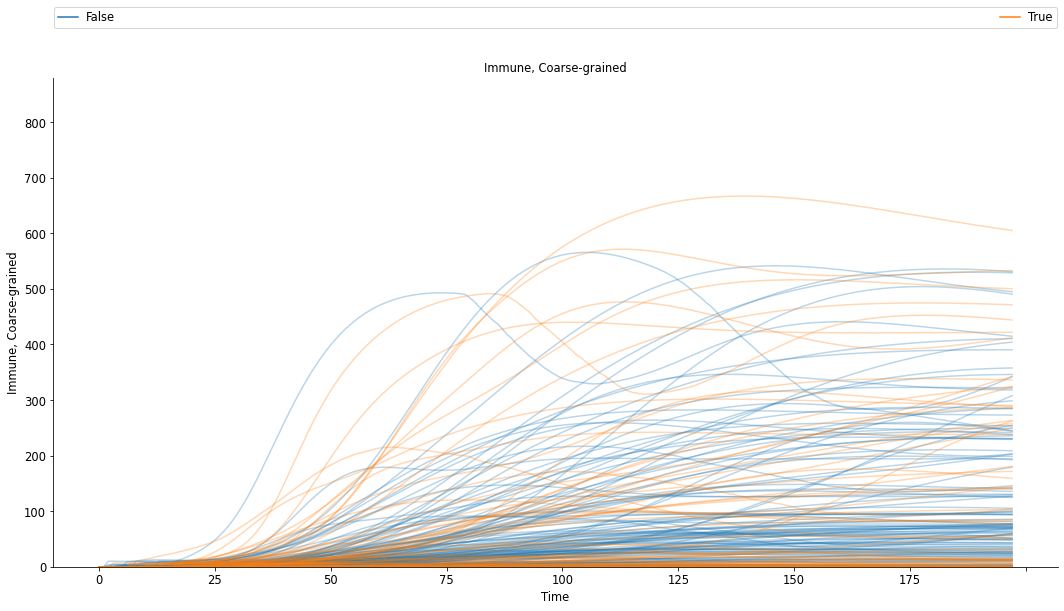

In [155]:
nice_lines(Uncertainsim_df,d_sim_all,out_to_show = 'Immune',title = "Immune, Coarse-grained",group_by="Immune_category",alpha=0.3,legend=True,zero=True,yupperlim = 880)